# Air Polution Challenge
### Iris Winkler, Carlos Duque, Johannes Gooth

neuefische can-ds-24-2

The Air Pollution Challenge on Zindi is focused on predicting air quality in various cities around the world using satellite data. Participants in this challenge are tasked with using machine learning techniques to estimate pollution levels, specifically PM2.5 concentrations. The challenge leverages data that spans across different geographical locations and conditions, providing a platform for developers to test and enhance their predictive modeling skills in real-world scenarios.

The competition is designed to address the growing issue of urban air pollution, providing insights and solutions that can help in managing air quality in densely populated cities. The use of satellite data in this context allows for a wide-reaching analysis that can cover areas where ground-based sensors might not be available, thus filling crucial data gaps in global environmental health studies.

For more detailed discussions and resources related to this challenge, including data sets and participant discussions, you can visit the official challenge page on Zindi's website: Urban Air Pollution Challenge on Zindi.

## Set-Up the Working Environment

In [8]:
# Avoid restarting Kernel 
%load_ext autoreload
%autoreload 2

import sys
# setting path
sys.path.append('../')

import os


# Import of relevant packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from src.preprocessing.basic_functions_preprocessing import * 
from src.evaluation.evaluation_functions import *
from src.train.train_model import *
from src.visualization.plot_functions import *

from sklearn.linear_model import LinearRegression

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet #maybe we don't need this
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

# Set random seed 
RSEED = 7
warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

## Import the Data

In [9]:
# Import the data into a Pandas DataFrame
df_train = pd.read_csv('../data/Train.csv')
df_test = pd.read_csv('../data/Test.csv')

## Quick Look at the Data

In [ ]:
# Display first 5 rows of the train DataFrame
df_train.head()

In [ ]:
# Display first 5 rows of the test DataFrame
df_test.head()

## Train-Test Split
The test_df holds the final evaluation dataset for the Air Pollution challenge. To ensure that we do not use this data until our final model is ready, we will also divide the train_df into training and testing subsets. This will allow us to assess our models effectively during the optimization process:

In [10]:
# Define your features and target variable
X = df_train.drop('target', axis=1)  # Features (all columns except 'not.fully.paid')
y = df_train['target']               # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)

# Checking the dimensions of the splits
print("Training set features shape:", X_train.shape)
print("Training set target shape:", y_train.shape)
print("Testing set features shape:", X_test.shape)
print("Testing set target shape:", y_test.shape)

Training set features shape: (21389, 81)
Training set target shape: (21389,)
Testing set features shape: (9168, 81)
Testing set target shape: (9168,)


## Explore the Data

### Shape of the DataFrames

In [ ]:
# Shape of the train DataFrame
X_train.shape

The train DataFrame has 81 columns and 30557 rows.

In [ ]:
# Shape of the test DataFrame
df_test.shape

The test DataFrame has 77 columns and 16136 rows. 

Thus, the train and test DataFrames have differnt columns. We will analyze the differences between the columns of two the DataFrames by comparing their column names:

In [11]:
# Get sets of column names for both DataFrames
columns_X_train = set(X_train.columns)
columns_df_test = set(df_test.columns)
    
# Find columns that are unique to each DataFrame
unique_to_df_train = list(columns_X_train - columns_df_test)

print(unique_to_df_train)

['target_count', 'target_max', 'target_variance', 'target_min']


The SampleSubmission file clearly states that only the 'target' column is the target value of our model (aka the amount of Pm2.5) and should be predicted.  Therefore, 'target_variance', 'target_count', 'target_max', 'target_min' could only be considered as additional features. However, training a machine learning model on features that do not appear in the test data can lead to several issues and is generally not recommended. Here are some key points to consider:
1. Generalization Ability: The primary goal of a machine learning model is to generalize well from the training data to unseen data. If the model is trained on features that are not available in the test data, it might learn patterns that are not applicable when making predictions in real-world scenarios or during evaluation, leading to poor performance.
2. Overfitting: Training on features not present in the test set can cause the model to overfit to the training data. Overfitting occurs when a model learns noise or irrelevant details in the training data instead of capturing the underlying patterns applicable more broadly. This typically results in high accuracy on training data but poor accuracy on unseen (test) data.
3. Feature Relevance: Features used in training should ideally be representative of the data the model will ultimately work with, including the test set and any real-world application data. Features that do not appear in the test set might not be relevant or available when the model is deployed, making them practically useless and potentially misleading during the training phase.
4. Model Complexity: Including irrelevant or unavailable features increases the complexity of the model unnecessarily. This not only affects the model's efficiency but can also complicate the model maintenance and interpretability.
5. Resource Allocation: Training on irrelevant features consumes computational resources and time, which could be better spent on feature engineering, model tuning, or training with relevant features that improve the model's performance on the test set.

Therefore, we decided to drop the other unique columns.

### Columns in the DataFrames

Next, we will check the column names of our DataFrames:

In [ ]:
# Columns in the dataframe
X_train.columns

Not all column names are lowercase and use underscores instead of spaces. To adhere to Python naming conventions, we'll convert all column names in the train and test DataFrames to lowercase and replace spaces with underscores.

More information about the column names can be found on https://developers.google.com/earth-engine/datasets/catalog/sentinel-5p.

Next, we will identify the different datatypes present in our datasets:

### Datatypes

In [ ]:
# Checking for the data-types
X_train.info()

 | Data-Type | Result |
|:-|:-|
| *object* | There are three features (columns) with an object data-type in our dataset: 'Place ID X Date', 'Place ID' and 'Date'. This means, there are strings or mixed data-types in this column. <br> - Since 'Date' means the date when the measurement was performed, this needs to be changed into a datetime format. |
| *float65* | Floats are the data-types of the remaining features (columns). We consider rounding at a later stage.

Next, we will check for missing values in the dataset.

### Missing Values

In [ ]:
# Checking for missing values ('NaN'/'None')
X_train.isnull().sum()

In [ ]:
# plotting percentage of missing values per column
msno.bar(X_train)

In [ ]:
# plotting the matrix of missing values
msno.matrix(X_train)

There are few instances where missing values co-occur, and there appears to be no discernible pattern in the distribution of missing data. Consequently, it seems that the missing data occurs randomly.

We deliberated on whether to retain or discard columns containing missing values through a thorough examination of the scientific literature:

### Dicussion of feature relevance based on scientific literature review

1. ***Methane (CH4) itself*** is not directly related to PM2.5 concentrations, as it does not directly contribute to particulate matter levels. 

    -> drop columns.

2. ***Sulfur dioxide (SO2)*** is closely related to PM2.5. SO2 is a significant precursor to sulfate aerosols, which are a major component of fine particulate matter (PM2.5) in the atmosphere. Here's how the relationship works:

    Chemical Transformations: When SO2 is emitted into the atmosphere, it can undergo various chemical reactions, particularly with hydroxyl radicals. This transformation leads to the formation of sulfuric acid (H2SO4), which can further react or nucleate to form sulfate particles.
    Secondary Particulate Formation: These sulfate particles contribute to secondary particulate matter, significantly influencing the concentration of PM2.5. This process is especially relevant in urban areas and regions with high fossil fuel combustion rates, where SO2 emissions are substantial.
    Environmental and Health Impact: The sulfate component of PM2.5 is known for its ability to degrade air quality and cause health problems, including respiratory and cardiovascular issues.
    Regulation and Control: Due to its role in forming PM2.5, controlling SO2 emissions is a critical strategy for reducing overall particulate matter levels and improving air quality.
    Understanding the link between SO2 and PM2.5 is crucial for environmental policy and implementing effective air quality management strategies​ (MDPI)​.

    -> keep columns

3. ***Aerosols*** are closely related to PM2.5. In the context of air pollution, "aerosol" refers to the suspension of fine solid particles or liquid droplets in air or another gas. These can include a wide range of particles, such as dust, pollen, soot, smoke, and liquid droplets, which are small enough to be suspended in the atmosphere.

    PM2.5 specifically refers to particulate matter that has a diameter of less than 2.5 micrometers. These fine particles are a subset of aerosols and are significant from both environmental and health perspectives because they can penetrate deep into the lungs and even enter the bloodstream, causing various health issues.

    Aerosols can be generated from both natural sources, such as volcanic eruptions and forest fires, and human-made sources, such as vehicle emissions and industrial processes. The study and management of aerosols, particularly PM2.5, are crucial for air quality monitoring and public health protection.

    -> keep columns

4. ***Cloud characteristics*** such as cloud fraction, height, pressure at the base and top, optical depth, and surface albedo can influence PM2.5 levels, although often indirectly. Here’s how these factors might play a role:

    1. **Cloud Fraction and Optical Depth**: These determine the amount of sunlight that reaches the Earth's surface, which can affect photochemical reactions in the atmosphere. These reactions are crucial for the formation of secondary pollutants that contribute to PM2.5. For instance, lower sunlight due to high cloud cover can reduce the rate of photochemical smog formation, potentially lowering PM2.5 levels.

    2. **Cloud Height and Pressure**: The height and pressure of clouds can influence atmospheric circulation and weather patterns, which in turn affect air pollution dispersion. Higher clouds and different pressure levels can lead to changes in wind patterns, possibly dispersing or concentrating pollutants like PM2.5.

    3. **Surface Albedo**: This refers to the Earth's surface ability to reflect sunlight. Surfaces with high albedo (like those covered with snow or light-colored materials) reflect more solar radiation, which can reduce ground-level temperatures and affect thermal circulations. These changes can impact how pollutants are mixed and dispersed in the lower atmosphere.

    4. **Clouds and Precipitation**: Clouds are also related to precipitation processes. Precipitation can remove pollutants from the atmosphere, a process known as wet deposition. When particulate matter like PM2.5 is washed out of the atmosphere by rain or snow, it leads to temporary improvements in air quality.

    In summary, while clouds don't directly emit or absorb PM2.5, their presence and characteristics can significantly alter meteorological conditions, thereby influencing the levels and distribution of particulate matter indirectly through changes in sunlight exposure, weather patterns, and precipitation.

    -> keep columns

5. ***Formaldehyde (HCHO)*** is related to PM2.5 primarily through secondary formation processes in the atmosphere. Formaldehyde is a volatile organic compound (VOC) that can act as a precursor to secondary organic aerosols (SOAs), which are a component of PM2.5. Here’s how this relationship works:

    1. **Chemical Reactions**: Formaldehyde in the atmosphere can undergo photochemical reactions driven by sunlight. These reactions can produce radicals and other compounds that further react to form secondary organic aerosols.

    2. **Contribution to PM2.5**: The SOAs formed from formaldehyde and other VOCs contribute to the overall mass of PM2.5 in the atmosphere. These aerosols can be significant, especially in urban and industrial areas with high levels of VOC emissions.

    3. **Air Quality Impact**: Because formaldehyde is involved in the formation of particulate matter, controlling VOC emissions (including formaldehyde) is important for managing PM2.5 levels and improving air quality.

    The link between HCHO and PM2.5 underscores the complexity of air pollution chemistry and the importance of monitoring a wide range of pollutants to effectively manage and mitigate air quality issues.

    -> keep columns

6. ***Carbon monoxide (CO)*** is not a direct component of PM2.5, but it is often correlated with PM2.5 concentrations in the atmosphere, primarily due to shared sources. Here’s how CO is related to PM2.5:

    1. **Common Sources**: Both CO and PM2.5 are often emitted from the same sources, such as motor vehicles, biomass burning, and industrial processes. This commonality means that areas with high CO levels often also have high PM2.5 levels due to simultaneous emissions of various pollutants.

    2. **Indicator of Combustion Efficiency**: CO is a product of incomplete combustion. High levels of CO can indicate poor combustion efficiency, which is also likely to produce higher amounts of particulate matter, including PM2.5. For example, inefficient fuel burning in engines or heaters can release both CO and a variety of particulate pollutants.

    3. **Atmospheric Chemistry**: While CO does not directly form PM2.5, it participates in atmospheric chemical reactions that can influence the levels of other pollutants that do form PM2.5. For instance, CO can react in the atmosphere to form secondary pollutants that contribute to the overall particulate load.

    4. **Air Quality Management**: Because of the correlation between the sources of CO and PM2.5, measures to reduce CO emissions (such as improving fuel combustion efficiency or upgrading vehicle emission standards) can also lead to reductions in PM2.5 concentrations.

    Thus, while CO is not a direct precursor or component of PM2.5, its presence is associated with conditions that can lead to increased levels of particulate matter. Monitoring CO levels can help in assessing combustion-related pollution and formulating strategies to control overall air pollution, including PM2.5.

    -> keep columns

7. ***Ozone (O3)*** is not directly a component of PM2.5, but it is related to particulate matter formation through atmospheric chemistry interactions. Here’s how ozone is connected to PM2.5:

    1. **Secondary Organic Aerosols (SOAs)**: Ozone plays a crucial role in the formation of secondary organic aerosols. Ozone can react with volatile organic compounds (VOCs) emitted from sources such as vehicles, industrial processes, and vegetation. These reactions often occur in the presence of sunlight and lead to the formation of new particulate matter, contributing to PM2.5 levels.

    2. **Photochemical Smog**: Ozone is a major component of photochemical smog, which includes a mixture of air pollutants including particulate matter. The same conditions that favor the formation of ozone (such as sunny, warm days) also promote the formation of PM2.5 from precursor gases like VOCs and nitrogen oxides (NOx).

    3. **Oxidizing Capacity**: Ozone has strong oxidizing properties, which can transform primary emissions into more reactive species that can then nucleate or condense to form particulate matter. This process can transform less harmful emissions into particles small enough to be classified as PM2.5.

    4. **Indicator of Air Quality**: Elevated levels of ozone and PM2.5 often occur together under certain meteorological conditions, particularly in urban environments. Thus, high ozone days can often also be high PM2.5 days, especially during periods of stagnant air that prevent the dispersion of pollutants.

    In summary, while ozone itself does not make up PM2.5, it influences the atmospheric processes that lead to the formation of PM2.5. Managing ozone levels, especially in urban areas, is therefore important not only for controlling ozone itself but also for managing levels of fine particulate matter.

    -> keep columns

8. ***Nitrogen dioxide (NO2)*** is related to PM2.5, primarily through its role in the formation of secondary particulate matter. Here’s how NO2 contributes to PM2.5 levels:

    1. **Formation of Nitrate Aerosols**: NO2 reacts with atmospheric compounds to form nitrate aerosols, which are a significant component of PM2.5. This reaction typically occurs with ammonia (NH3) to produce particulate nitrates, which increase the concentration of fine particulate matter in the atmosphere.

    2. **Photochemical Reactions**: NO2 plays a crucial role in photochemical reactions that produce ozone and other photochemical oxidants. These oxidants can further react with volatile organic compounds (VOCs) and other precursors to form secondary organic aerosols (SOAs), contributing to PM2.5 levels.

    3. **Urban Air Pollution**: In urban environments, where NO2 emissions are high due to traffic and industrial activities, the contribution of NO2 to PM2.5 formation is particularly significant. The density of emission sources accelerates the formation of both nitrate aerosols and SOAs.

    4. **Indicator of Combustion Sources**: Similar to carbon monoxide (CO), NO2 is often emitted from combustion sources such as vehicles and power plants. High levels of NO2 can indicate significant combustion-related pollution, which often corresponds with increased PM2.5 from various combustion byproducts.

    Managing NO2 emissions is important for controlling PM2.5 levels, especially in urban areas where exposure to NO2 and fine particulates can pose significant health risks. Reducing NO2 emissions from vehicles and industrial sources is crucial for improving air quality and reducing particulate matter pollution.

    -> keep columns

9. ***Wind*** is significantly related to PM2.5 levels, primarily through its role in the dispersion and transport of these fine particles. Here’s how wind impacts PM2.5:

    1. **Dispersion of Particles**: Wind helps to disperse air pollutants, including PM2.5. Higher wind speeds can dilute concentrations of particulate matter by spreading them over a wider area, potentially reducing the pollutant levels in a specific locale while distributing these particles over a larger region.

    2. **Transport of Pollutants**: Wind can carry PM2.5 from their sources to distant locations. This means that areas downwind of major pollution sources (like industrial areas, urban centers, or areas with heavy traffic) can experience elevated PM2.5 levels due to wind transport.

    3. **Influence on Air Quality**: Wind direction and speed are critical factors in determining daily air quality. For example, winds blowing from industrial zones towards residential areas can lead to higher exposure to PM2.5 for populations in those residential areas.

    4. **Interaction with Weather Patterns**: Wind is also influenced by broader weather patterns and geographical features. For instance, mountainous regions can experience "channeling" effects that may concentrate or disperse air pollutants differently, affecting PM2.5 concentrations.

    5. **Impact on Emission Sources**: In situations where wind influences the operation of pollution sources (such as in open mining, construction sites, or agriculture), it can increase the generation of particulate matter by stirring up dust and other particles.

    In air quality modeling and environmental monitoring, understanding the patterns of wind in a region is crucial for predicting PM2.5 levels and managing pollution control strategies effectively. Wind data is often used alongside other meteorological factors to develop accurate forecasts and public health advisories regarding air quality.

    -> keep columns

10. ***Temperature*** is related to PM2.5 levels through several mechanisms:

    1. **Chemical Reaction Rates**: Higher temperatures can increase the rate of chemical reactions in the atmosphere that lead to the formation of secondary particulate matter. For example, higher temperatures accelerate the photochemical reactions involving volatile organic compounds (VOCs) and nitrogen oxides (NOx), which form secondary organic aerosols and nitrate aerosols, respectively, contributing to PM2.5 levels.

    2. **Atmospheric Stability**: Temperature influences the stability of the atmosphere. Warmer temperatures tend to increase atmospheric instability, which can enhance the vertical mixing of pollutants and disperse air pollutants, including PM2.5. Conversely, lower temperatures, especially during night or winter, can lead to temperature inversions that trap pollutants close to the ground, increasing PM2.5 concentrations.

    3. **Emission Sources**: Temperature can affect emissions from various sources. For instance, residential heating demand increases during colder temperatures, potentially increasing emissions of PM2.5 from combustion processes.

    4. **Volatility of Organic Compounds**: Temperature changes affect the volatility of organic compounds. Higher temperatures can increase the volatility, enhancing the formation of secondary organic aerosols as more vapors are available to participate in atmospheric reactions.

    These relationships highlight the complex interplay between meteorological conditions and air quality, making temperature a critical factor in modeling and managing PM2.5 pollution.

    -> keep columns

11. ***Yumidity*** is related to PM2.5 concentrations in the atmosphere through various mechanisms:

    1. **Particle Growth**: High humidity levels can lead to the growth of particulate matter. Water vapor condenses on particles, causing them to grow in size and mass. This can increase the PM2.5 concentration as smaller particles grow to become part of the PM2.5 classification.

    2. **Chemical Reactions**: Humidity can also influence the chemical reactions that form secondary particles, such as sulfates and nitrates. For example, sulfur dioxide (SO2) and nitrogen oxides (NOx) can react with water vapor to form these secondary particulate matters, which are components of PM2.5.

    3. **Hygroscopic Properties**: Many particles in the PM2.5 category are hygroscopic, meaning they can absorb moisture from the air. This absorption can change the chemical composition and physical properties of the particles, potentially making them more hazardous or altering their ability to be filtered by the respiratory system.

    4. **Agglomeration**: Higher humidity can enhance the agglomeration of particles, where smaller particles stick together to form larger particles. While this might reduce the number of particles classified as PM2.5 by mass, it can also make them more likely to deposit in the respiratory tract.

    Understanding the role of humidity in PM2.5 dynamics is crucial for accurate air quality forecasting and health risk assessment, especially in regions with high humidity levels.

    -> keep columns

12. ***The angles*** in the features refer to geographical and/or directional measurements related to the data, such as the angles of wind direction, satellite data acquisition angles, or other related metrics. Angles can be important in air quality modeling if they relate to how pollutants disperse or how satellite observations are made relative to the Earth's surface.

    For example, wind direction, which could be represented by angles, is crucial for understanding how air pollutants travel and disperse across different areas. Similarly, satellite observation angles might affect the accuracy and relevance of the measurements for specific locations, especially in complex urban geometries where building shadows or reflections might influence sensor readings.

    -> keep columns

To prevent any alteration of the dataset through the creation of synthetic data, we have decided to retain the NaN values in the columns we preserve.

Next, we will examine the dataset for any zero values.



### 0-values

For features with 'angles' in their names, along with 'cloud_fraction' and 'weekday', zero values are permissible. However, in all other features, the presence of zero values may indicate an error.

To focus on columns where zero values might signify an error, we initially exclude columns that contain the word 'angle' in their headers:


In [12]:
# Create a new DataFrame without columns containing the word 'angle' and 'cloud_fraction'
df_filtered_noangle_nocloud = X_train[[col for col in X_train.columns if 'angle' not in col and 'cloud_fraction' not in col]]

print(df_filtered_noangle_nocloud)

            Place_ID X Date        Date Place_ID  target_min  target_max   
15534  GJOPSKI X 2020-02-12  2020-02-12  GJOPSKI        11.0       162.0  \
15205  G4CKKFV X 2020-02-14  2020-02-14  G4CKKFV         5.0       129.0   
9537   ARTRJ6I X 2020-03-24  2020-03-24  ARTRJ6I        21.0        50.0   
30134  YLLOKEY X 2020-02-02  2020-02-02  YLLOKEY         8.0        58.0   
21061  NW6MZ2E X 2020-01-20  2020-01-20  NW6MZ2E        30.0        85.0   
...                     ...         ...      ...         ...         ...   
5699   5QYHA81 X 2020-01-09  2020-01-09  5QYHA81         1.0        57.0   
10742  C39T5GU X 2020-01-24  2020-01-24  C39T5GU        42.0        99.0   
16921  HR0OKCA X 2020-03-04  2020-03-04  HR0OKCA        21.0        74.0   
25796  THZR2TS X 2020-01-04  2020-01-04  THZR2TS        82.0       190.0   
28847  WOIRN9J X 2020-01-22  2020-01-22  WOIRN9J        74.0       172.0   

       target_variance  target_count  precipitable_water_entire_atmosphere   
15534    

In [13]:
# Check for zeros in all columns and count them
zero_counts = (df_filtered_noangle_nocloud == 0).sum()

# Filter and print entries where the sum is not zero
non_zero_counts = zero_counts[zero_counts != 0]
print("Number of zeros in each column:")
print(non_zero_counts)

Number of zeros in each column:
target_variance                                          35
L3_NO2_NO2_column_number_density                       1840
L3_NO2_NO2_slant_column_number_density                 1840
L3_NO2_absorbing_aerosol_index                         1840
L3_NO2_sensor_altitude                                 1840
L3_NO2_stratospheric_NO2_column_number_density         1840
L3_NO2_tropopause_pressure                             1840
L3_NO2_tropospheric_NO2_column_number_density          1840
L3_O3_O3_column_number_density                          443
L3_O3_O3_effective_temperature                          443
L3_CO_CO_column_number_density                          222
L3_CO_H2O_column_number_density                         222
L3_CO_cloud_height                                      222
L3_CO_sensor_altitude                                   222
L3_HCHO_HCHO_slant_column_number_density                222
L3_HCHO_tropospheric_HCHO_column_number_density         222
L3_HCHO_

The 'target_variance' column will be dropped during data preprocessing later on. Zero values in all other columns are likely indicative of errors.  

The occurrence of 0-values across all data for a specific air pollutant suggests that they originate from the same sensor, which was likely malfunctioning. To preserve the integrity of the dataset, we aim to avoid generating synthetic data. Nonetheless, to assess the impact of removing these potentially erroneous entries, we will now investigate how many columns contain 0-values that are likely errors:

In [14]:
# Calculate the number of zeros in each row 
df_filtered_noangle_nocloud['zero_count'] = (df_filtered_noangle_nocloud == 0).sum(axis=1) 

# Count the rows with 6 or more zeros 
number_of_rows_with_error_zero_values = (df_filtered_noangle_nocloud['zero_count'] >= 5).sum()

print(f"There are {number_of_rows_with_error_zero_values} rows with 0-values that likely indicate errors.")

There are 1840 rows with 0-values that likely indicate errors.


1840 rows constitute less than 10% of our observations. Consequently, we plan to exclude them later.

Next, we'll verify our analysis by examining plots of some of the data:

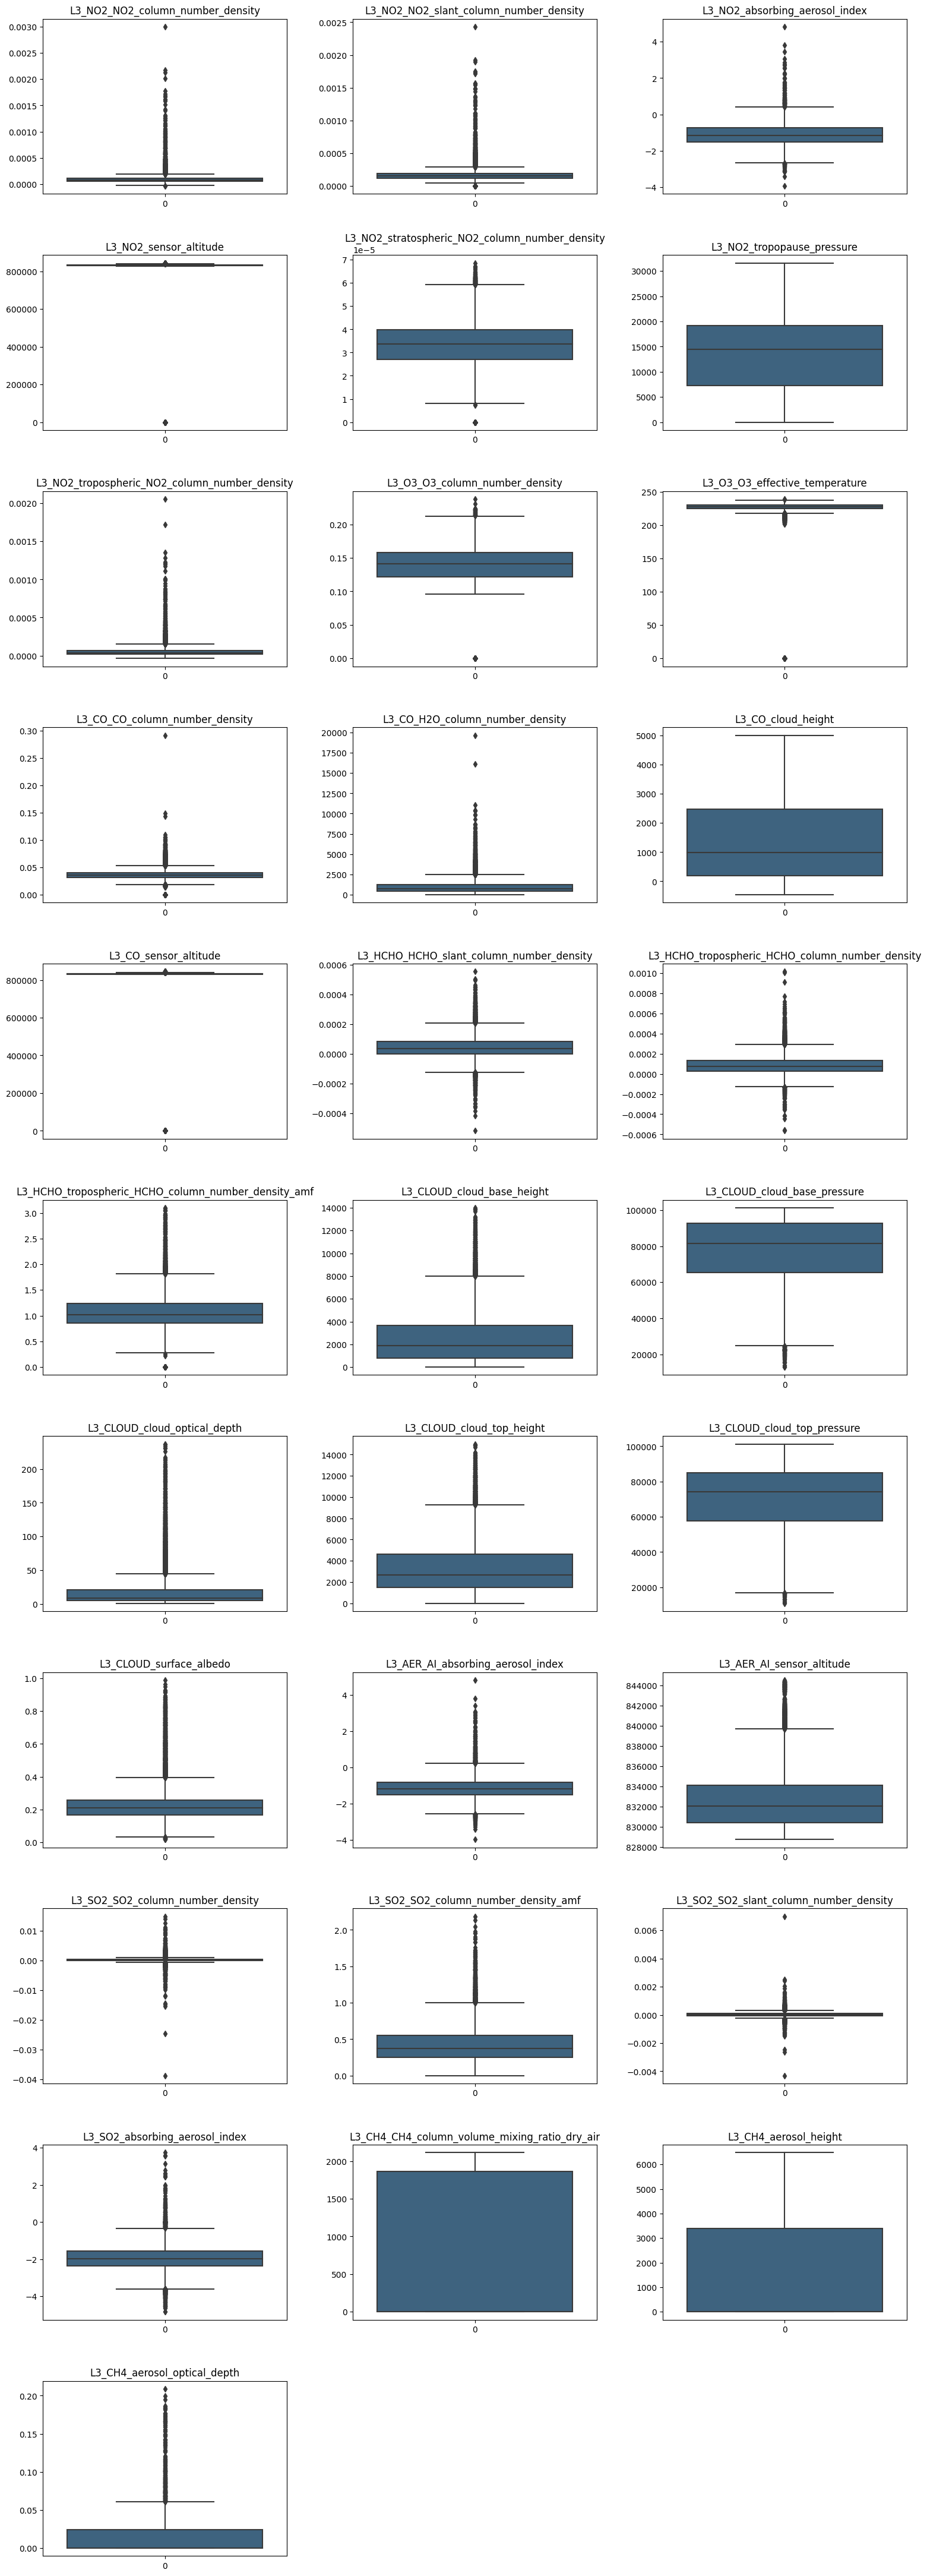

In [15]:
# Identify columns with missing values
columns_with_zeros = df_filtered_noangle_nocloud.columns[df_filtered_noangle_nocloud.isnull().any()]

# Filter the DataFrame to include only columns with missing values
data_missing = df_filtered_noangle_nocloud[columns_with_zeros]

# Assuming your DataFrame is named data_missing
num_columns = len(data_missing.columns)  # Get the number of columns in the DataFrame
cols_per_row = 3  # Number of plots per row (you can adjust this number as needed)

# Calculate the number of rows needed
num_rows = (num_columns + cols_per_row - 1) // cols_per_row  # Rounds up if not a perfect multiple

# Create a figure with the calculated number of subplots
fig, ax = plt.subplots(num_rows, cols_per_row, figsize=(16, 4 * num_rows))  # Adjusted height per row

count = 0
for item in data_missing.columns:
    sns.boxplot(data_missing[item], ax=ax[count // cols_per_row][count % cols_per_row], color='#33658A').set(title=item, xlabel='')
    count += 1

# Hide empty subplots if they exist
if count < num_rows * cols_per_row:
    for i in range(count, num_rows * cols_per_row):
        ax.flat[i].set_visible(False)

fig.tight_layout(pad=3)
plt.show()

Next, we will look at the descriptive statistics of our data:

### target-values distribution


<Axes: xlabel='target', ylabel='Count'>

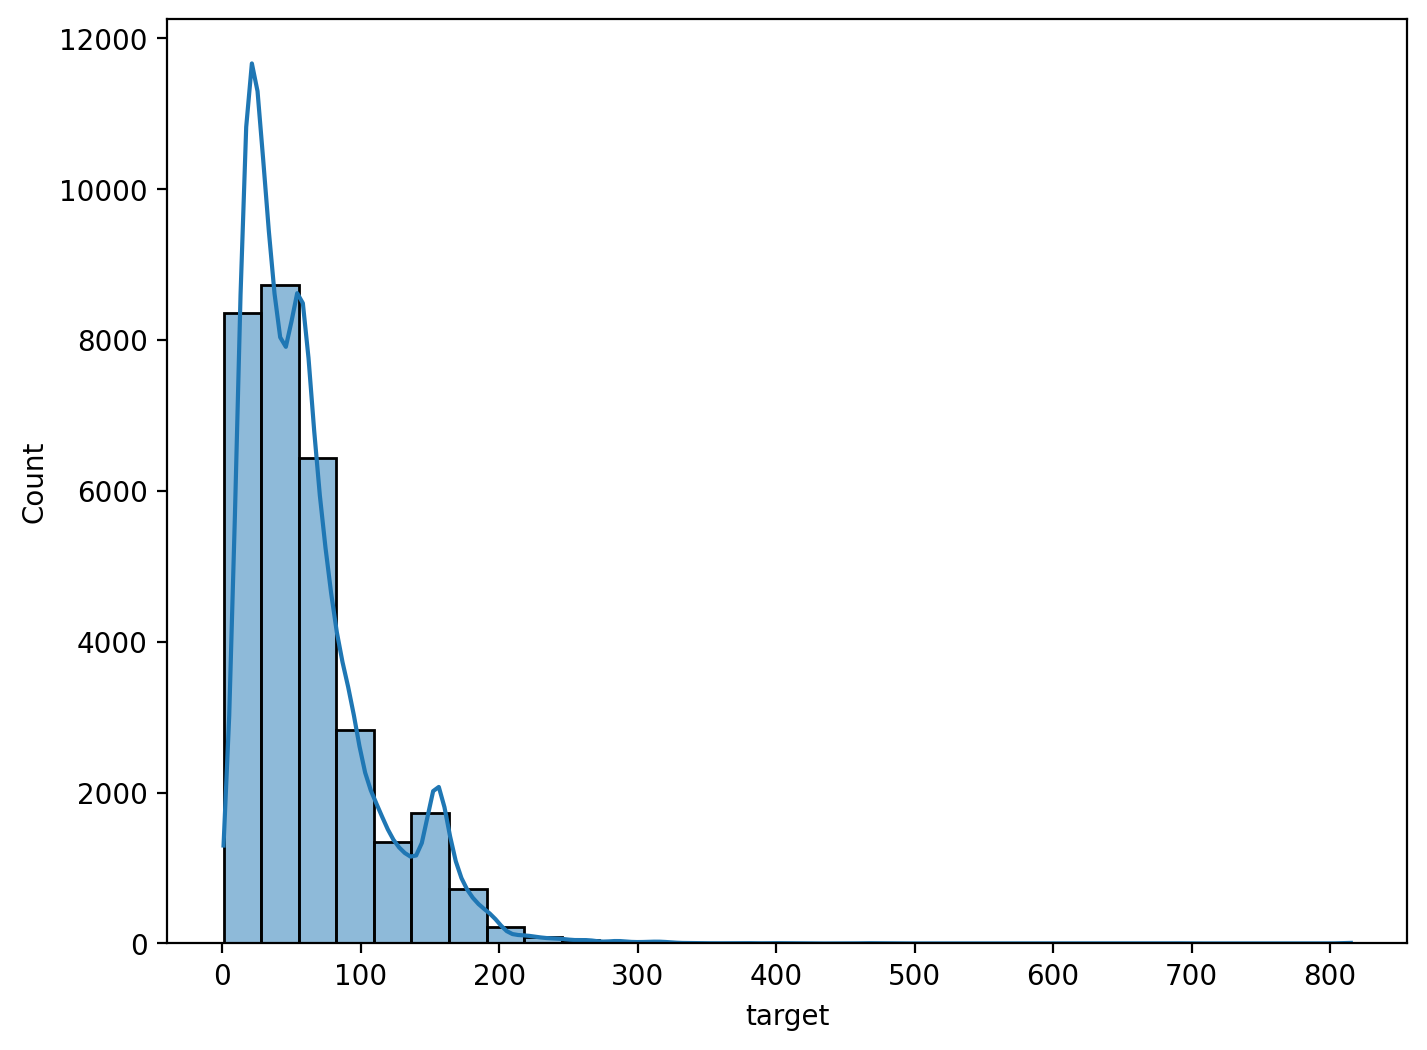

In [19]:
fig, ax = plt.subplots(figsize=(8,6),dpi=200)
sns.histplot(data=df_train, x="target",bins=30,kde=True,ax=ax)

<Axes: xlabel='target', ylabel='Count'>

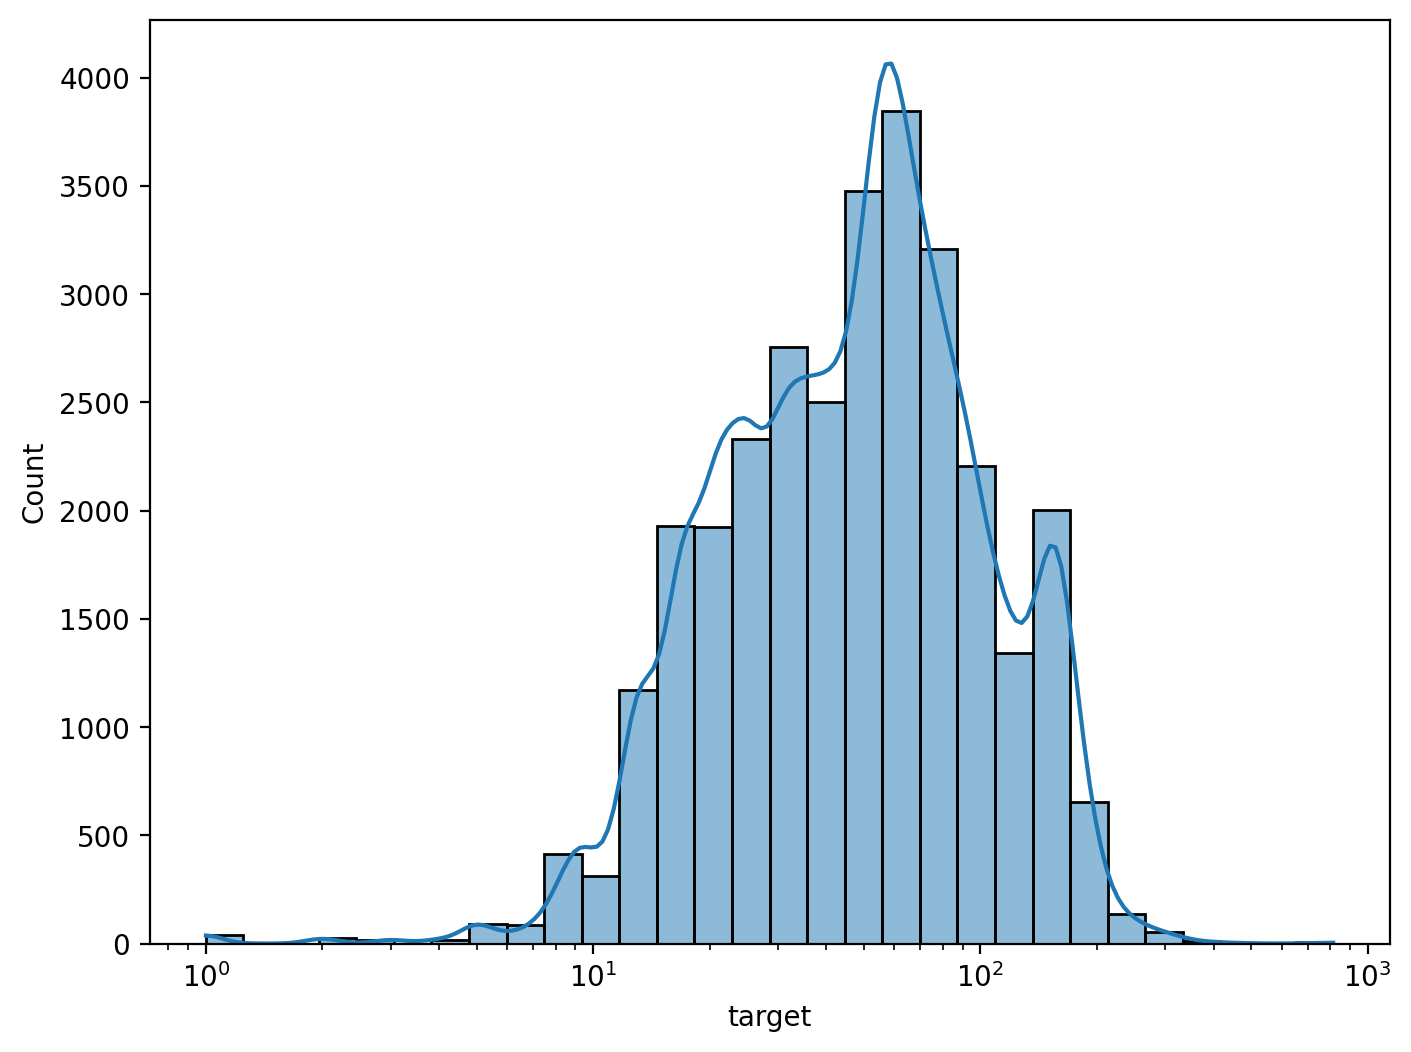

In [20]:
fig, ax = plt.subplots(figsize=(8,6),dpi=200)
sns.histplot(data=df_train, x="target",log_scale=True,bins=30,kde=True,ax=ax)

### Descriptive Statistics

In [ ]:
# Examining the descriptive statistics of the dataset
X_test.describe()

Now, we take a look on the correlation matrix of our data:

### Correlation Matrix

<Axes: >

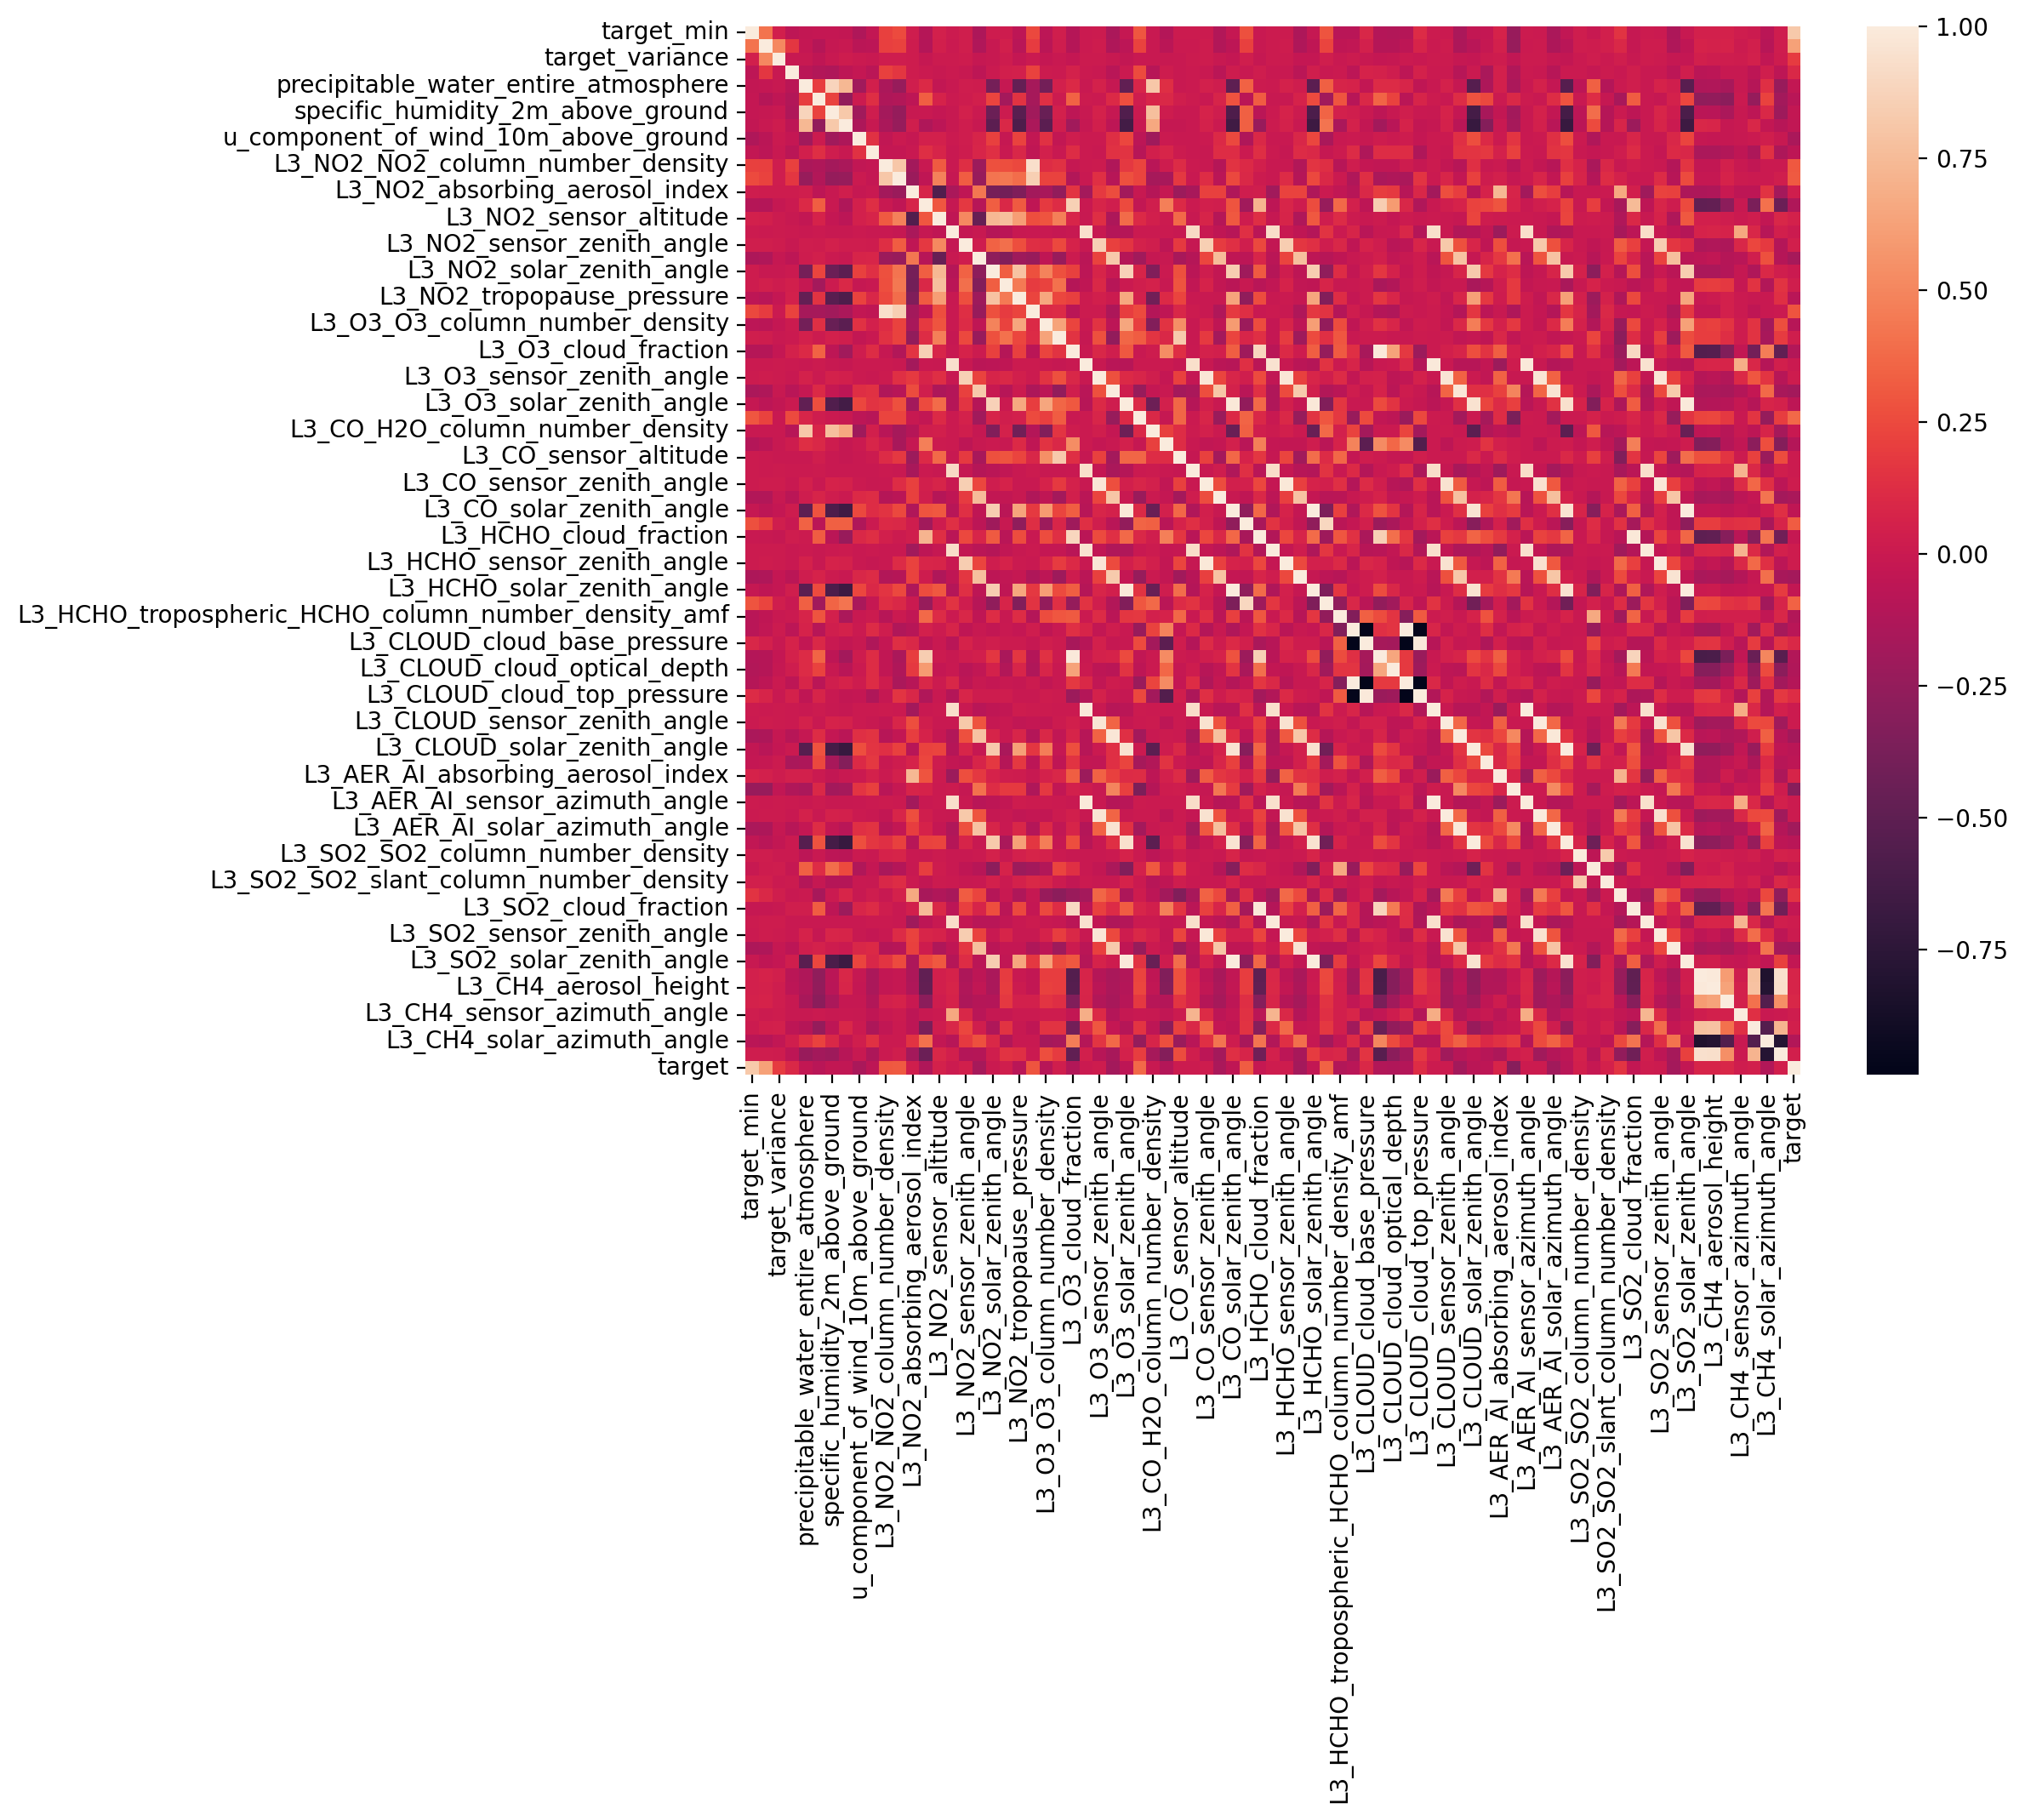

In [21]:
#remove columns with non-numerical values
df_train_num = X_train.drop(['Date', 'Place_ID', 'Place_ID X Date'], axis=1).join(y)

# correlation plot
fig, ax = plt.subplots(figsize=(10,8),dpi=200)
sns.heatmap(df_train_num.corr(), annot=False,ax=ax)

The density of the data points makes it difficult to derive useful information. As a result, we will refine the correlation matrix to highlight only high correlation values. Given that the satellite angles are inherently correlated, we will remove them from the matrix before replottng the heatmap:

In [22]:
# Create a new DataFrame without columns containing the word 'angle'
df_filtered_noangle = df_train_num[[col for col in df_train_num.columns if 'angle' not in col]]

print(df_filtered_noangle)

       target_min  target_max  target_variance  target_count   
15534        11.0       162.0         10399.10           163  \
15205         5.0       129.0          6122.12           142   
9537         21.0        50.0           992.04           192   
30134         8.0        58.0          2800.25            72   
21061        30.0        85.0          1949.34            48   
...           ...         ...              ...           ...   
5699          1.0        57.0          2002.48           101   
10742        42.0        99.0          2088.70            24   
16921        21.0        74.0          1563.77            47   
25796        82.0       190.0         10329.10            24   
28847        74.0       172.0          5803.24           154   

       precipitable_water_entire_atmosphere   
15534                             16.900000  \
15205                              0.862500   
9537                               3.650000   
30134                             14.535974

<Axes: >

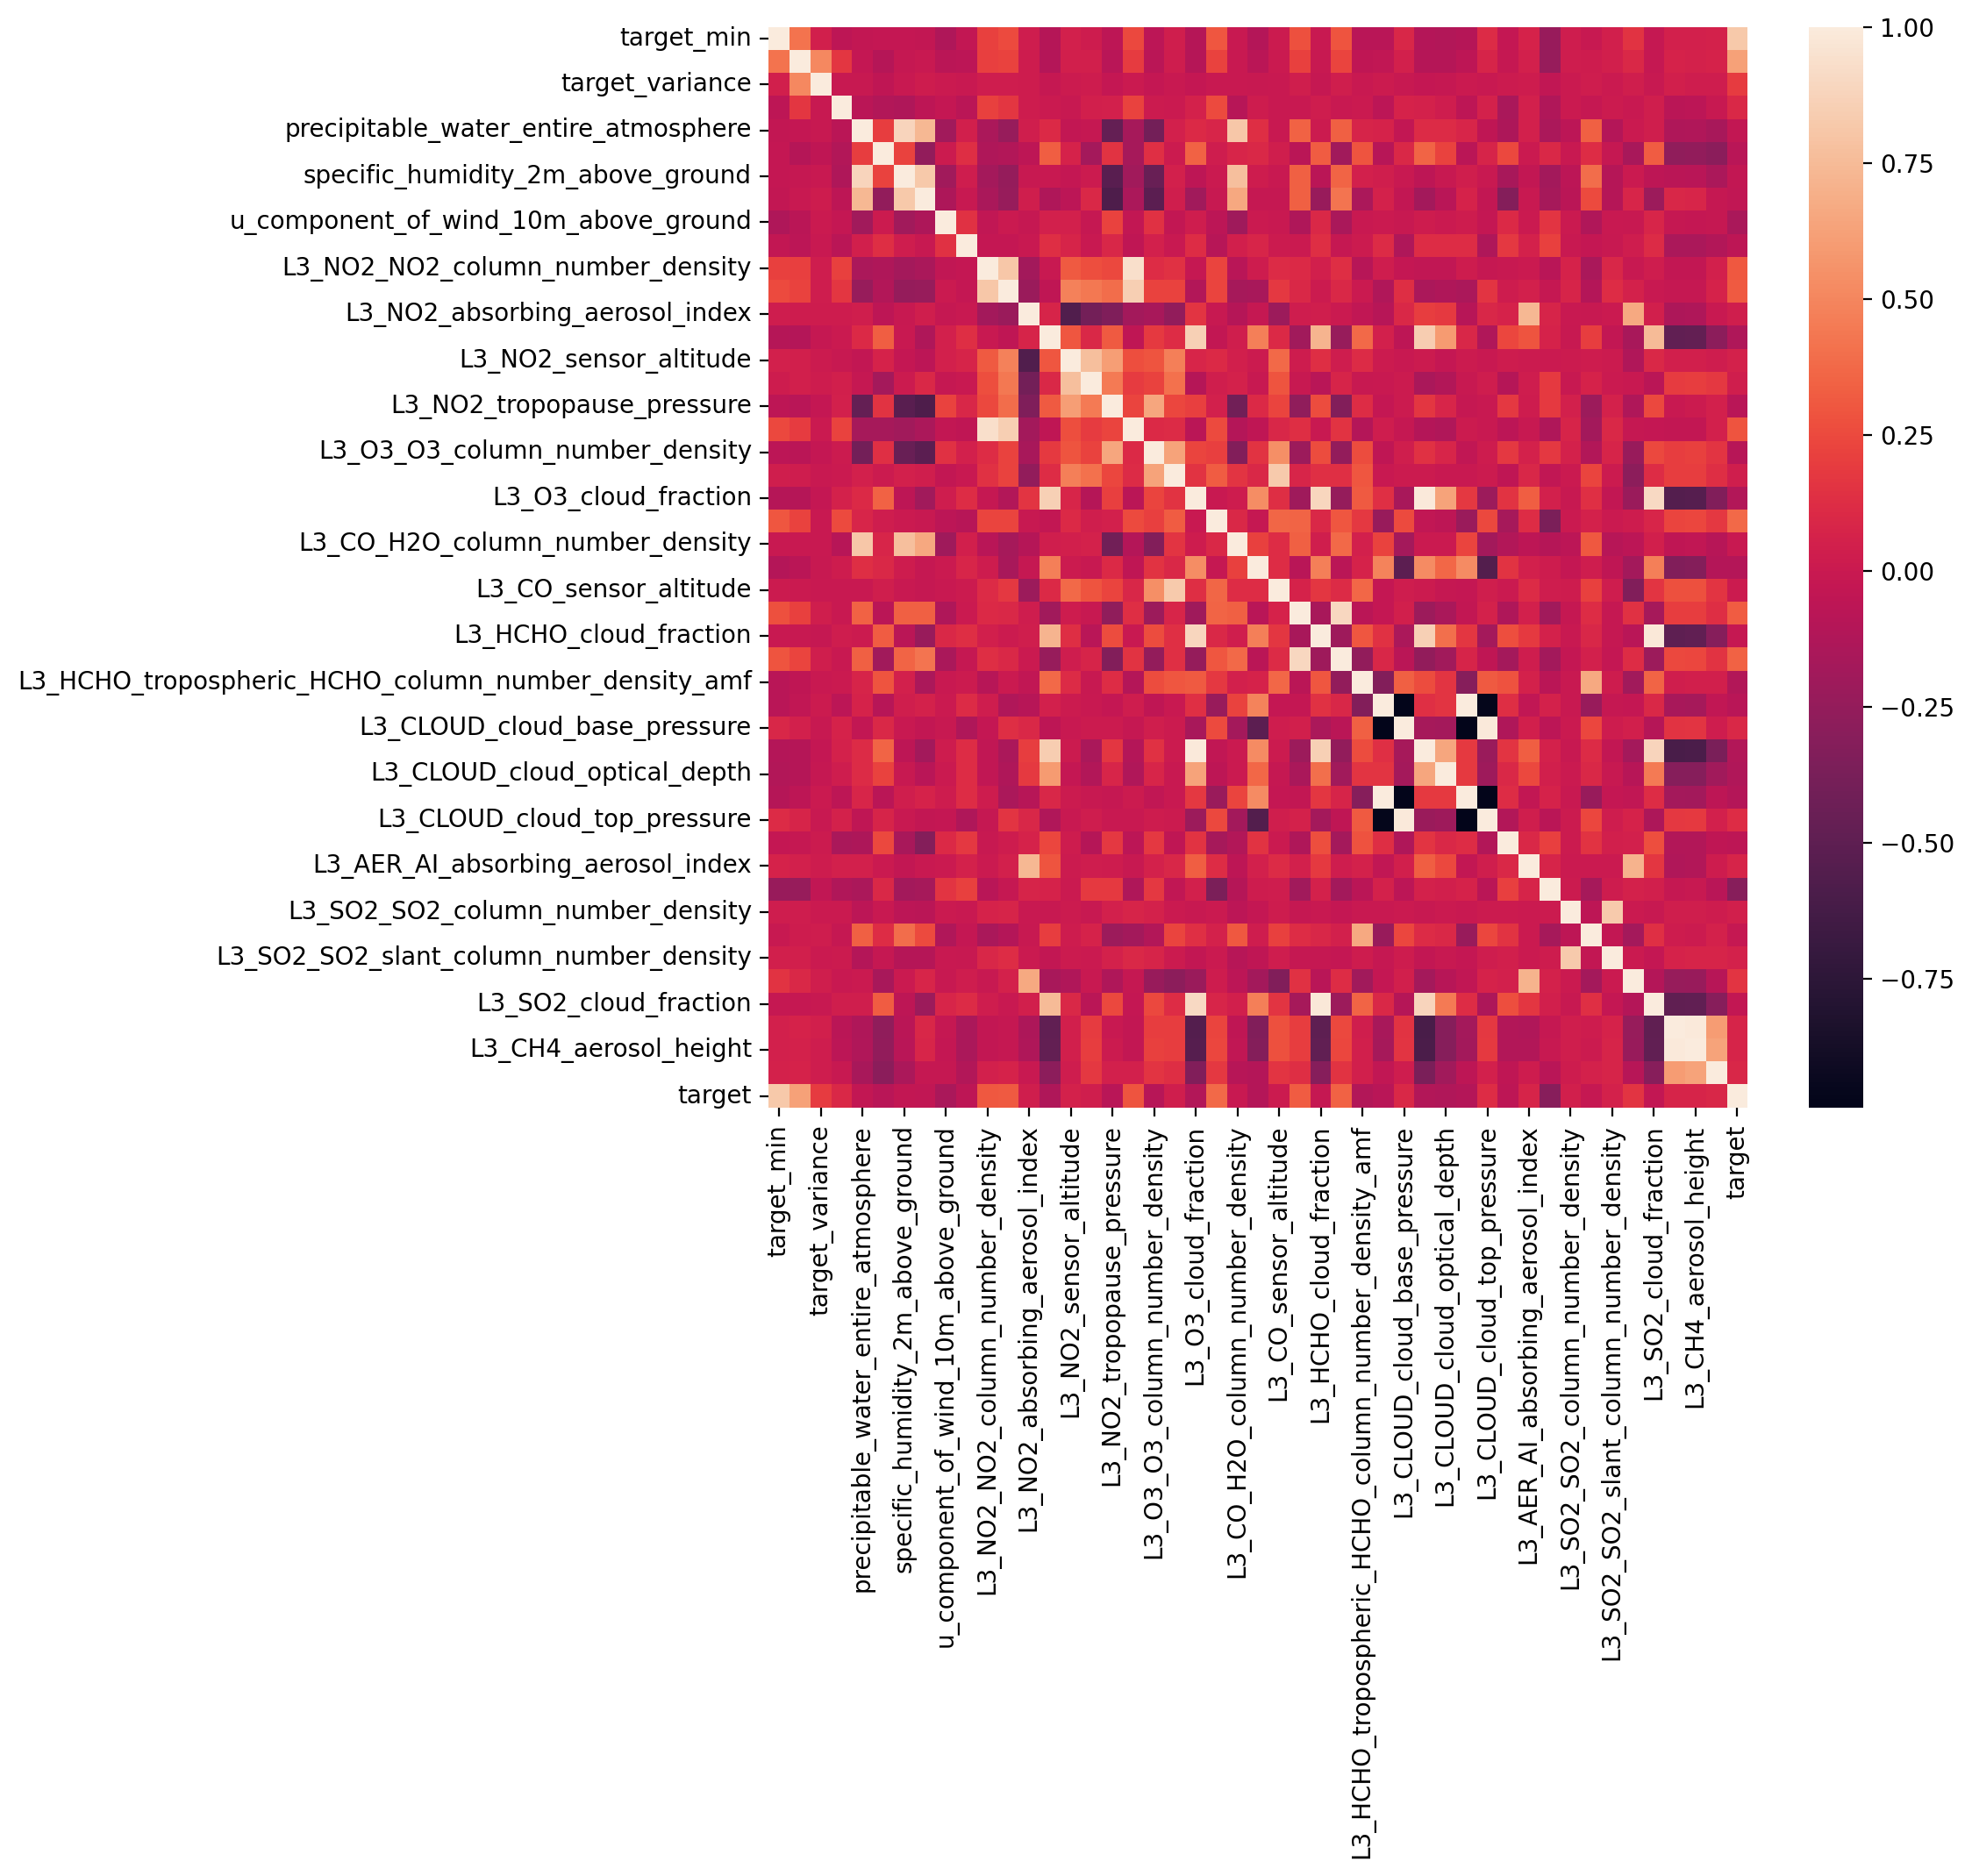

In [13]:
from matplotlib.colors import SymLogNorm

fig, ax = plt.subplots(figsize=(9,8),dpi=200)

sns.heatmap(df_filtered_noangle.corr(), ax=ax,annot=False)

# sns.heatmap(df_filtered_noangle.corr(), ax=ax,annot=False,
#             norm=SymLogNorm(linthresh=0.01, linscale=1, 
#                             vmin=-1, vmax=1, base=10),
#             cmap='coolwarm')


Now, we will filter for high correlation values. To achieve this, we first need to create a DataFrame containing the correlation matrix.

In [23]:
# Create the correlation matrix
corr_matrix = df_filtered_noangle.corr()

# Find correlations of other columns with 'target' where the absolute value of correlation is greater than 0.9
high_corr_with_target = corr_matrix['target'].abs().where(lambda x: abs(x) > 0.2).dropna()

print(high_corr_with_target)

target_min                                         0.821022
target_max                                         0.622676
L3_NO2_NO2_column_number_density                   0.302755
L3_NO2_NO2_slant_column_number_density             0.314200
L3_NO2_tropospheric_NO2_column_number_density      0.291523
L3_CO_CO_column_number_density                     0.377015
L3_HCHO_HCHO_slant_column_number_density           0.318350
L3_HCHO_tropospheric_HCHO_column_number_density    0.344558
L3_AER_AI_sensor_altitude                          0.307862
target                                             1.000000
Name: target, dtype: float64


The columns 'target_min', 'target_max', and 'target' will be excluded when training the models later. Despite this, some significant correlations remain evident.

## Preprocess the Data

In [24]:
X_train, y_train = preprocessing_df(X_train, y_train)

New dataframe shape: (17766, 72) (17766,)


In [25]:
X_test, y_test = preprocessing_df(X_test, y_test)

New dataframe shape: (7595, 72) (7595,)


In [ ]:
X_train.head()

## Preprocessing Pipeline

### Categorical vs numerical variables

In [27]:
# # Creating list for categorical predictors/features 
cat_features = ['place_id']
cat_features

['place_id']

In [28]:
# # Creating list for numerical predictors/features 
num_features = X_train.columns.tolist()
num_features.remove('place_id')
num_features

['date',
 'precipitable_water_entire_atmosphere',
 'relative_humidity_2m_above_ground',
 'specific_humidity_2m_above_ground',
 'temperature_2m_above_ground',
 'u_component_of_wind_10m_above_ground',
 'v_component_of_wind_10m_above_ground',
 'l3_no2_no2_column_number_density',
 'l3_no2_no2_slant_column_number_density',
 'l3_no2_absorbing_aerosol_index',
 'l3_no2_cloud_fraction',
 'l3_no2_sensor_altitude',
 'l3_no2_sensor_azimuth_angle',
 'l3_no2_sensor_zenith_angle',
 'l3_no2_solar_azimuth_angle',
 'l3_no2_solar_zenith_angle',
 'l3_no2_stratospheric_no2_column_number_density',
 'l3_no2_tropopause_pressure',
 'l3_no2_tropospheric_no2_column_number_density',
 'l3_o3_o3_column_number_density',
 'l3_o3_o3_effective_temperature',
 'l3_o3_cloud_fraction',
 'l3_o3_sensor_azimuth_angle',
 'l3_o3_sensor_zenith_angle',
 'l3_o3_solar_azimuth_angle',
 'l3_o3_solar_zenith_angle',
 'l3_co_co_column_number_density',
 'l3_co_h2o_column_number_density',
 'l3_co_cloud_height',
 'l3_co_sensor_altitude',
 

In [29]:
#from sklearn.pipeline import Pipeline

# Pipline for numerical features
# Initiating Pipeline and calling one step after another
# each step is built as a list of (key, value)
# key is the name of the processing step
# value is an estimator object (processing step)
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [30]:
#from sklearn.compose import ColumnTransformer

# Complete pipeline for numerical and categorical features
# 'ColumnTransformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

## Predictive Modelling using Pipelines and Grid Search

### Linear Regression Model - Basis Model
Now that we have a preprocessing pipeline, we can add a basis model on top (this sequence will also be handled by a Pipeline) and see how it performs using cross validation. 

Root Mean Squared Error: 25.76
R^2 Score: 0.69
Adj. R^2 Score: 0.69


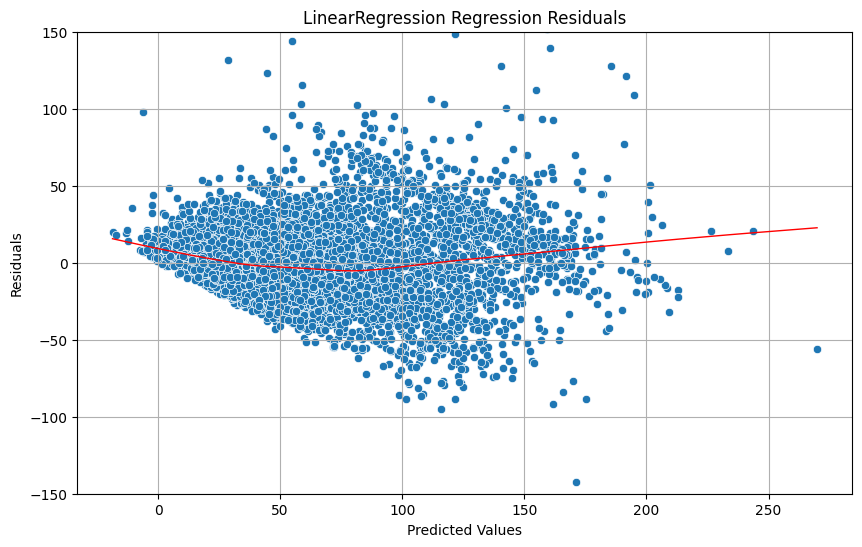

In [32]:
# Assuming 'preprocessor' is a pre-defined ColumnTransformer
# Building a full pipeline with our preprocessor and a Linear Regression model
pipe_linreg = Pipeline([
    ('preprocessor', preprocessor),
    ('linreg', LinearRegression())
])

# Final model evaluation using the test set
pipe_linreg.fit(X_train, y_train)  # Train the model on the entire training set
y_test_pred = pipe_linreg.predict(X_test)  # Predict the test set
y_train_pred = pipe_linreg.predict(X_train)  # Predict the train set

print_scores(X_train, y_train, y_train_pred)

plot_residuals(y_test,y_test_pred,'LinearRegression',y_limits=[-150,150])

### Scoring function

We will create a custom scoring function to evaluate the performance of the different grid searches

In [33]:
rmse_scoring = make_scorer(rmse_scorer, greater_is_better=False)

### Ridge Regression Model

**GridSearchCV**

Best score:
-27.64
Best parameters:
{'ridge__alpha': 1}
Root Mean Squared Error: 25.59
R^2 Score: 0.70
Adj. R^2 Score: 0.70


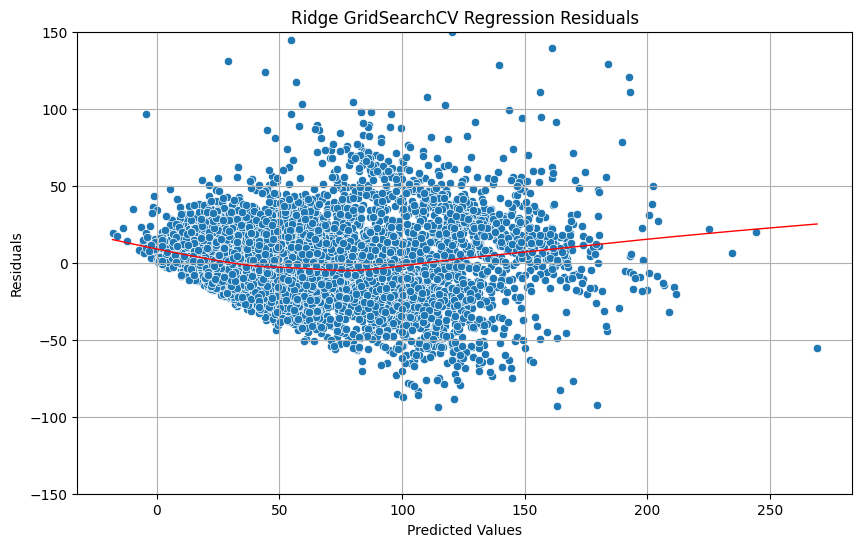

In [42]:
# Defining parameter space for grid-search
param_ridge = {
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]  # Regularization strength
}

pipe_model = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
    ])
    
best_model_ridge, y_test_pred = train_grid_cv(
                                X_train,X_test,y_train,y_test,pipe_model,param_ridge,
                                search_type='grid',reg_name='ridge',scoring_func = rmse_scoring)


plot_residuals(y_test,y_test_pred,'Ridge GridSearchCV',y_limits=[-150,150])


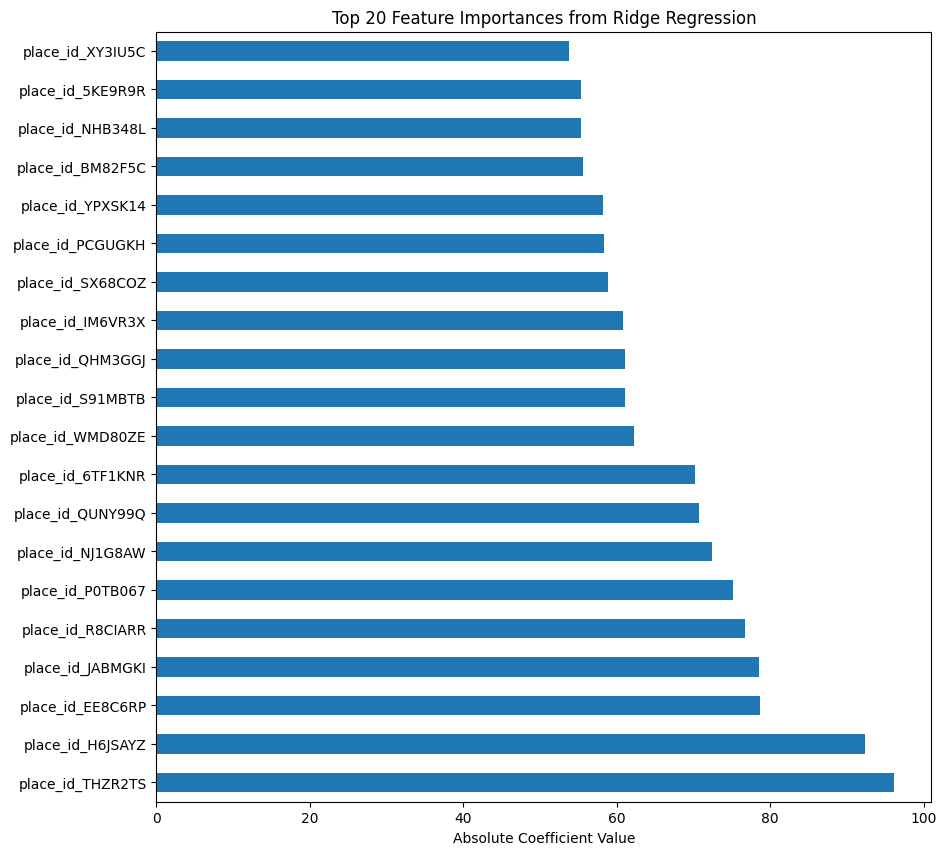

In [35]:
plot_most_important_features(best_model_ridge,'ridge',20)


**RandomizedSearchCV**

Best score:
-27.64
Best parameters:
{'ridge__alpha': 1}
Root Mean Squared Error: 25.59
R^2 Score: 0.70
Adj. R^2 Score: 0.70


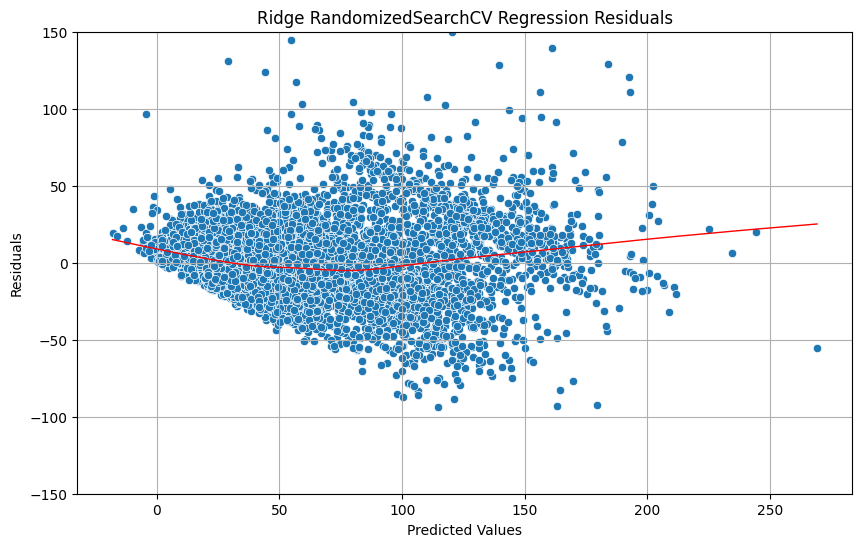

In [43]:
# Defining parameter space for grid-search
param_ridge = {
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]  # Regularization strength
}

pipe_model = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
    ])
    
best_model_ridge, y_test_pred = train_grid_cv(
                                X_train,X_test,y_train,y_test,pipe_model,param_ridge,
                                search_type='random',reg_name='ridge',scoring_func = rmse_scoring)

plot_residuals(y_test,y_test_pred,'Ridge RandomizedSearchCV',y_limits=[-150,150])

### Lasso Regression Model

**GridSearchCV**

/Users/carlosduque/Documents/neuefische/cgn-ds-24-2/project_2_ML/ds-air-pollution-challenge/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3499918.87147285, tolerance: 2900.2750975664558
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/carlosduque/Documents/neuefische/cgn-ds-24-2/project_2_ML/ds-air-pollution-challenge/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3428753.641480156, tolerance: 2973.8412594469814
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/carlosduque/Documents/neuefische/cgn-ds-24-2/project_2_ML/ds-air-pollution-challenge/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge.

Best score:
-27.64
Best parameters:
{'lasso__alpha': 0.001, 'lasso__max_iter': 1000}
Root Mean Squared Error: 25.60
R^2 Score: 0.70
Adj. R^2 Score: 0.70


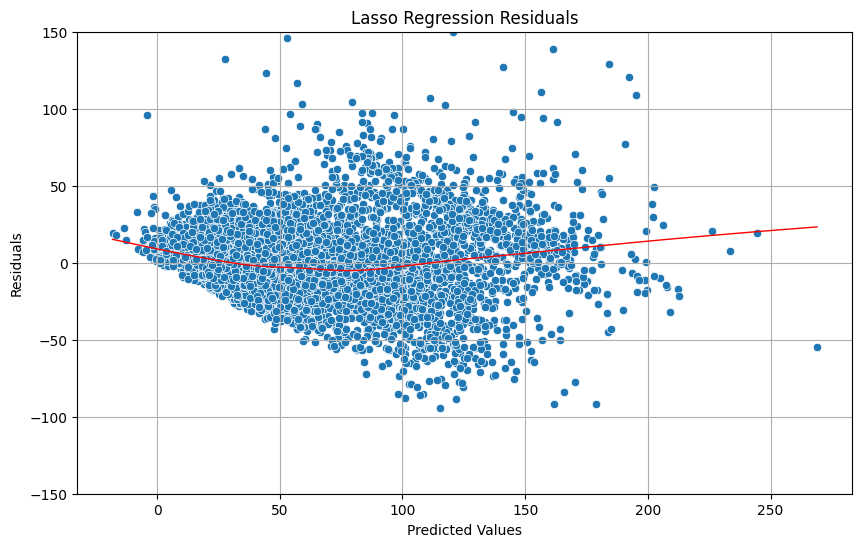

In [29]:
# Building a full pipeline with our preprocessor and a Lasso Regression model -- approx. 3.30 min running time

# Defining parameter space for grid-search
param_lasso = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1, 10],  # Regularization strength
    'lasso__max_iter': [1000, 5000, 10000],  # Number of iterations -> could change it to 5000, 10000, 100000 because of warnings too less iterations
    # 'lasso__tol': [0.01, 0.001, 0.0001]  # Tolerance for stopping criteria
}

pipe_model = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso())
    ])
    
best_model_lasso, y_test_pred = train_grid_cv(
                                X_train,X_test,y_train,y_test,pipe_model,param_lasso,
                                search_type='grid',reg_name='lasso',scoring_func = rmse_scoring)

plot_residuals(y_test,y_test_pred,'Lasso GridSearchCV',y_limits=[-150,150])

**RandomizedSearchCV**

/Users/carlosduque/Documents/neuefische/cgn-ds-24-2/project_2_ML/ds-air-pollution-challenge/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69605.32354417071, tolerance: 2739.7988529088084
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/carlosduque/Documents/neuefische/cgn-ds-24-2/project_2_ML/ds-air-pollution-challenge/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20321.650082152337, tolerance: 2973.8412594469814
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/carlosduque/Documents/neuefische/cgn-ds-24-2/project_2_ML/ds-air-pollution-challenge/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converg

Best score:
-27.65
Best parameters:
{'lasso__max_iter': 10000, 'lasso__alpha': 0.001}
Root Mean Squared Error: 25.58
R^2 Score: 0.70
Adj. R^2 Score: 0.70


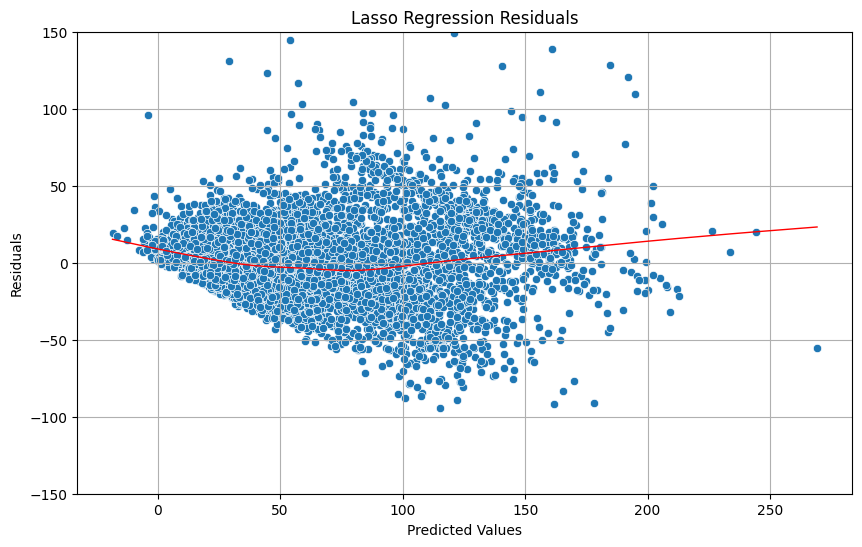

In [28]:
param_lasso = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1, 10],  # Regularization strength
    'lasso__max_iter': [1000, 5000, 10000],  # Number of iterations -> could change it to 5000, 10000, 100000 because of warnings too less iterations
    # 'lasso__tol': [0.01, 0.001, 0.0001]  # Tolerance for stopping criteria
}

pipe_model = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso())
    ])
    
best_model_lasso_random, y_test_pred = train_grid_cv(
                                X_train,X_test,y_train,y_test,pipe_model,param_lasso,
                                search_type='random',reg_name='lasso',scoring_func = rmse_scoring)

plot_residuals(y_test,y_test_pred,'Lasso RandomizedSearchCV',y_limits=[-150,150])

### Elastic Net Regression Model

**GridSearchCV**

Best score:
-27.58
Best parameters:
{'elastic_net__alpha': 0.001, 'elastic_net__l1_ratio': 0.9}
Root Mean Squared Error: 25.65
R^2 Score: 0.70
Adj. R^2 Score: 0.70


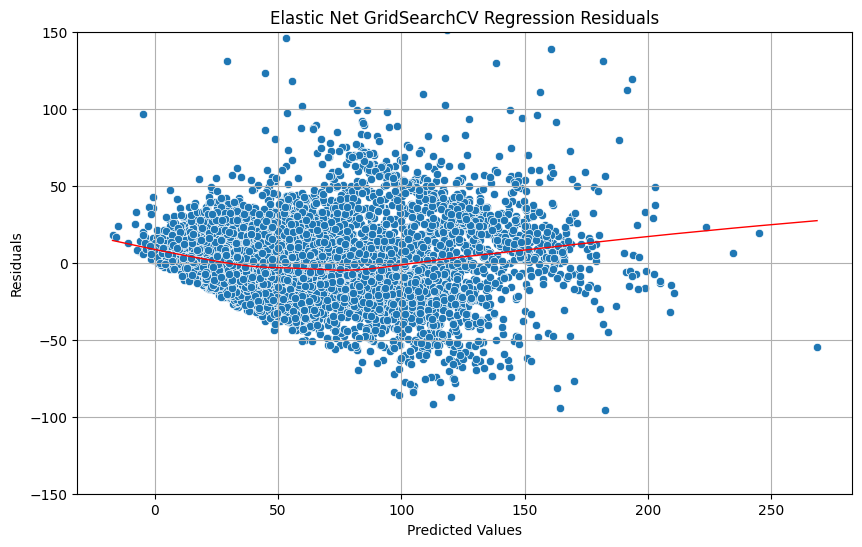

In [45]:
# Defining parameter space for grid-search
param_elastic = {
    'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'elastic_net__l1_ratio': [0.1, 0.5, 0.9]  # Blend of L1 and L2 regularization
}

pipe_model = Pipeline([
    ('preprocessor', preprocessor),
    ('elastic_net', ElasticNet())
    ])
    
best_model_elastic, y_test_pred = train_grid_cv(
                                X_train,X_test,y_train,y_test,pipe_model,param_elastic,
                                search_type='grid',reg_name='elastic_net',scoring_func = rmse_scoring)

plot_residuals(y_test,y_test_pred,'Elastic Net GridSearchCV',y_limits=[-150,150])

**RandomizedSearchCV**

Best score:
-27.58
Best parameters:
{'elastic_net__l1_ratio': 0.9, 'elastic_net__alpha': 0.001}
Root Mean Squared Error: 25.65
R^2 Score: 0.70
Adj. R^2 Score: 0.70


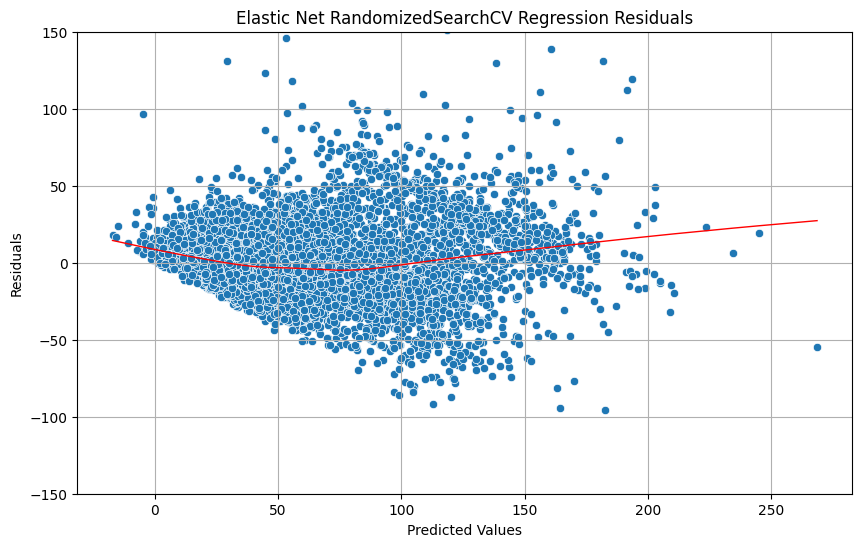

In [39]:
# Defining parameter space for grid-search
param_elastic = {
    'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'elastic_net__l1_ratio': [0.1, 0.5, 0.9]  # Blend of L1 and L2 regularization
}

pipe_model = Pipeline([
    ('preprocessor', preprocessor),
    ('elastic_net', ElasticNet())
    ])
    
best_model_elastic_random, y_test_pred = train_grid_cv(
                                X_train,X_test,y_train,y_test,pipe_model,param_elastic,
                                search_type='random',reg_name='elastic_net',scoring_func = rmse_scoring)

plot_residuals(y_test,y_test_pred,'Elastic Net RandomizedSearchCV',y_limits=[-150,150])

### K-Nearest Neighbors (KNN) Model

**GridSearchCV**

This first code was running for over 5 hours so I stopped it and asked for a more efficient try: Randomized Search instead of GridSearch was suggested...

In [ ]:
# # Building a full pipeline with our preprocessor and KNN Regressor -- > 5h running time
# pipe_KNN = Pipeline([
#     ('preprocessor', preprocessor),
#     ('KNN', KNeighborsRegressor())
# ])

# # Defining parameter space for grid-search
# param_KNN = {'KNN__n_neighbors': list(range(1, 100)),
#                 'KNN__weights': ['uniform', 'distance'],
#                 'KNN__metric': ['euclidean', 'manhattan', 'minkowski'],
#                 'KNN__p': [1, 2, 3, 4, 5],
#                 'KNN__algorithm': ['ball_tree', 'kd_tree', 'brute']
#                }

# # Setting up RandomizedSearchCV
# rmse_scoring = make_scorer(rmse_scorer, greater_is_better=False)  # Set `greater_is_better=False` because a lower RMSE is better
# grid_KNN = GridSearchCV(pipe_KNN, param_grid=param_KNN, cv=5, scoring=rmse_scoring, 
#                            verbose=0, n_jobs=-1)

# # Fit the model
# grid_KNN.fit(X_train, y_train)

# # Show best parameters
# print('Best score:\n{:.2f}'.format(grid_KNN.best_score_))
# print("Best parameters:\n{}".format(grid_KNN.best_params_))

# # Save best model (including fitted preprocessing steps) as best_model 
# best_model_KNN = grid_KNN.best_estimator_

# Predict using the optimized model
# y_test_pred = best_model_KNN.predict(X_test)

# # # Calculating Error measures
# print_scores(X_test, y_test, y_test_pred)

Alternative with less computational time:

In [40]:

# # # Defining parameter space for grid-search
# param_KNN = {
#     'KNN__n_neighbors': [5, 10, 15, 20, 30, 50],  # Reduced and focused range
#     'KNN__weights': ['uniform'],  # Chose one weighting scheme
#     'KNN__metric': ['euclidean', 'manhattan'],  # Limited to two metrics
#     'KNN__algorithm': ['ball_tree', 'kd_tree']  # More efficient algorithms
# }

# best_model_KNN, y_test_pred = train_grid_cv(
#                                 X_train,X_test,y_train,y_test,KNeighborsRegressor(),preprocessor,param_KNN,
#                                 search_type='grid',reg_name='KNN',scoring_func = rmse_scoring)

# plot_residuals(y_test,y_test_pred,'KNN GridSearchCV',y_limits=[-150,150])



Another option:

In [ ]:
# # Building a full pipeline with our preprocessor and KNN Regressor and RandomizedSearchCV -- approx .10 min running time
# pipe_KNN = Pipeline([
#     ('preprocessor', preprocessor),
#     ('KNN', KNeighborsRegressor())
# ])

# # Defining parameter space for randomized-search
# param_KNN = {
#     'KNN__n_neighbors': list(range(1, 100)),
#     'KNN__weights': ['uniform', 'distance'],
#     'KNN__metric': ['minkowski'],
#     'KNN__p': [1, 2, 3, 4, 5],
#     'KNN__algorithm': ['ball_tree', 'kd_tree', 'brute']
# }

# best_model_KNN, y_test_pred = train_grid_cv(
#                                 X_train,X_test,y_train,y_test,KNeighborsRegressor(),preprocessor,param_KNN,
#                                 search_type='random',reg_name='KNN',scoring_func = rmse_scoring)

# plot_residuals(y_test,y_test_pred,'KNN RandomizedSearchCV',y_limits=[-150,150])



**RandomizedSearchCV and dimension reduction with TruncatedSVD**

In [ ]:
# # Reducing the number of parameters and using RandomizedSearchCV
# pipe_KNN = Pipeline([
#     ('preprocessor', preprocessor),
#     ('dimension_reduction', TruncatedSVD(n_components=50)),  # Adjust components as needed
#     ('KNN', KNeighborsRegressor())
# ])

# # Reduced parameter grid
# param_KNN = {
#     'KNN__n_neighbors': [5, 10, 15],
#     'KNN__weights': ['uniform'],
#     'KNN__metric': ['euclidean', 'manhattan']
# }

# # Using RandomizedSearchCV
# rmse_scoring = make_scorer(rmse_scorer, greater_is_better=False)  # Set `greater_is_better=False` because a lower RMSE is better
# randomized_search = RandomizedSearchCV(pipe_KNN, param_distributions=param_KNN, n_iter=10, cv=3, scoring=rmse_scoring, verbose=0, n_jobs=-1)
# randomized_search.fit(X_train, y_train)

# # After fitting, make predictions on the test set
# y_test_pred = randomized_search.predict(X_test)

# # # Calculating Error measures
# print_scores(X_test, y_test, y_test_pred)

# # Plotting the residuals
# residuals = y_test - y_test_pred # Calculate residuals
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=y_test_pred, y=residuals)
# sns.regplot(x=y_test_pred, y=residuals, lowess=True, scatter=False, line_kws={'color': 'red', 'lw': 1}) # Add a lowess line using regplot
# plt.title('KNN Randomized and Truncted')
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.grid(True)
# plt.ylim(-150, 150) # Set y-axis limits
# plt.show()

### Descission Tree Regression Model

**GridSearchCV**

Best score:
-37.25
Best parameters:
{'dectree__ccp_alpha': 0.0, 'dectree__max_depth': 10, 'dectree__min_impurity_decrease': 0.0, 'dectree__min_samples_leaf': 4, 'dectree__min_samples_split': 2, 'dectree__splitter': 'random'}
Root Mean Squared Error: 36.88
R^2 Score: 0.38
Adj. R^2 Score: 0.37


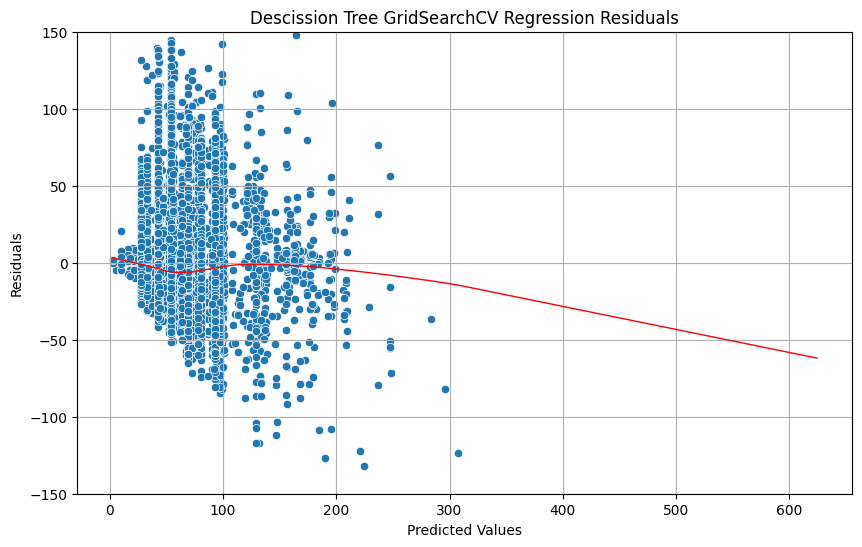

In [41]:
# Building a full pipeline with our preprocessor and a Decission Tree Regressor
pipe_dectree = Pipeline([
    ('preprocessor', preprocessor),
    ('dectree', DecisionTreeRegressor())
])

# Defining parameter space for grid-search. 
param_dectree = {'dectree__splitter': ['best', 'random'],
                'dectree__max_depth': [1, 10, 100],
                'dectree__min_samples_split': [2, 5, 10],
                'dectree__min_samples_leaf': [1, 2, 4],
                'dectree__min_impurity_decrease': [0.0, 0.01, 0.1],
                'dectree__ccp_alpha': [0.0, 0.01, 0.1]
               }


best_model_dectree, y_test_pred = train_grid_cv(
                                X_train,X_test,y_train,y_test,pipe_dectree,param_dectree,
                                search_type='grid',reg_name='dectree',scoring_func = rmse_scoring)

plot_residuals(y_test,y_test_pred,'Descission Tree GridSearchCV',x_limits=[0,300],y_limits=[-150,150])


**RandomizedSearchCV**

In [ ]:
# Building a full pipeline with our preprocessor and a Decission Tree Regressor
pipe_dectree = Pipeline([
    ('preprocessor', preprocessor),
    ('dectree', DecisionTreeRegressor())
])

# Defining parameter space for randomized-search
param_dectree = {'dectree__splitter': ['best', 'random'],
                'dectree__max_depth': [1, 10, 100],
                'dectree__min_samples_split': [2, 5, 10],
                'dectree__min_samples_leaf': [1, 2, 4],
                'dectree__min_impurity_decrease': [0.0, 0.01, 0.1],
                'dectree__ccp_alpha': [0.0, 0.01, 0.1]
               }

best_model_dectree_random, y_test_pred = train_grid_cv(
                                X_train,X_test,y_train,y_test,pipe_dectree,param_dectree,
                                search_type='random',reg_name='dectree',scoring_func = rmse_scoring)

plot_residuals(y_test,y_test_pred,'Descission Tree RandomizedSearchCV',x_limits=[0,300],y_limits=[-150,150])


### Random  Forest Regression Model

**GridSearchCV**

In [ ]:
# Building a full pipeline with our preprocessor and a Random Forest Regressor
pipe_random_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor())
])

# Defining parameter space for grid-search
param_random_forest = {
    'rf__max_features': ['auto', 'sqrt', 'log2']
}

best_model_rf, y_test_pred = train_grid_cv(
                                X_train,X_test,y_train,y_test,pipe_random_forest,param_random_forest,
                                search_type='grid',reg_name='rf',scoring_func = rmse_scoring)

plot_residuals(y_test,y_test_pred,'Random Forest GridSearchCV',y_limits=[-150,150])

**RandomizedSearchCV**

In [ ]:
# Building a full pipeline with our preprocessor and a Random Forest Regressor
pipe_random_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor())
])

# Defining parameter space for randomized-search
param_random_forest = {
    'rf__max_features': ['auto', 'sqrt', 'log2']
}

best_model_rf_random, y_test_pred = train_grid_cv(
                                X_train,X_test,y_train,y_test,pipe_random_forest,param_random_forest,
                                search_type='random',reg_name='rf',scoring_func = rmse_scoring)

plot_residuals(y_test,y_test_pred,'Random Forest GridSearchCV',y_limits=[-150,150])

### AdaBoost Regression Model

**GridSearchCV**

Best score:
-40.18
Best parameters:
{'adaboost__base_estimator__max_depth': 3, 'adaboost__learning_rate': 0.01, 'adaboost__n_estimators': 50}
Root Mean Squared Error: 39.94
R^2 Score: 0.27
Adj. R^2 Score: 0.27


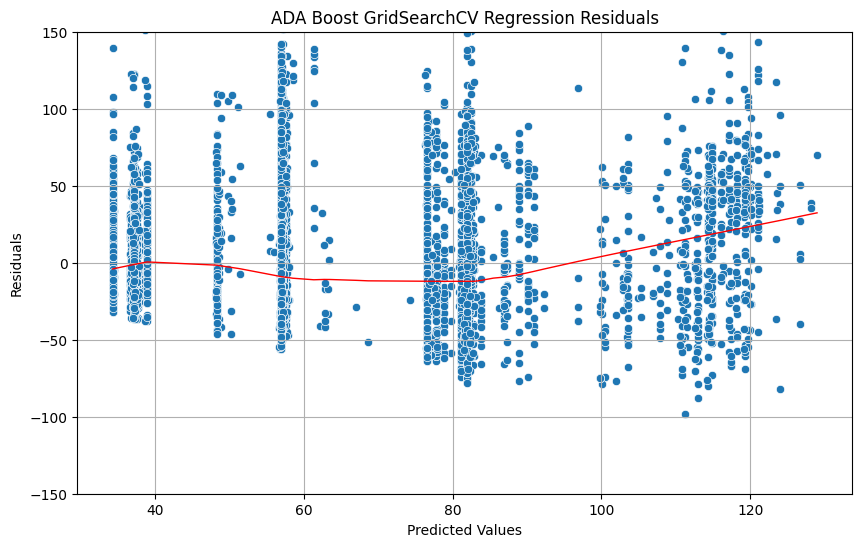

In [36]:
# Defining parameter space for randomized-search
param_adaboost = {
    'adaboost__n_estimators': [50, 100, 300],
    'adaboost__learning_rate': [0.01, 0.1, 1.0],
    'adaboost__base_estimator__max_depth': [1, 2, 3]  # Depths for the decision trees
}

pipe_adaboost = Pipeline([
    ('preprocessor', preprocessor),
    ('adaboost', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=42))
])

best_model_ada, y_test_pred = train_grid_cv(
                                X_train,X_test,y_train,y_test,
                                pipe_adaboost,param_adaboost,
                                search_type='grid',reg_name='adaboost',scoring_func = rmse_scoring)

plot_residuals(y_test,y_test_pred,'ADA Boost GridSearchCV',y_limits=[-150,150])

**RandomizedSearchCV**

In [46]:
# Defining parameter space for randomized-search
param_adaboost = {
    'adaboost__n_estimators': [50, 100, 300],
    'adaboost__learning_rate': [0.01, 0.1, 1.0],
    'adaboost__base_estimator__max_depth': [1, 2, 3]  # Depths for the decision trees
}

pipe_adaboost = Pipeline([
    ('preprocessor', preprocessor),
    ('adaboost', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=42))
])

best_model_ada_random, y_test_pred = train_grid_cv(
                                X_train,X_test,y_train,y_test,
                                pipe_adaboost,param_adaboost,
                                search_type='random',reg_name='adaboost',scoring_func = rmse_scoring)

plot_residuals(y_test,y_test_pred,'ADA Boost RandomizedSearchCV',x_limits=[-150,150],y_limits=[-150,150])

### XGBoost Model

**GridSearchCV**

Best score:
-27.20
Best parameters:
{'xgb__colsample_bytree': 0.5, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 500, 'xgb__subsample': 0.9}
Root Mean Squared Error: 23.68
R^2 Score: 0.74
Adj. R^2 Score: 0.74


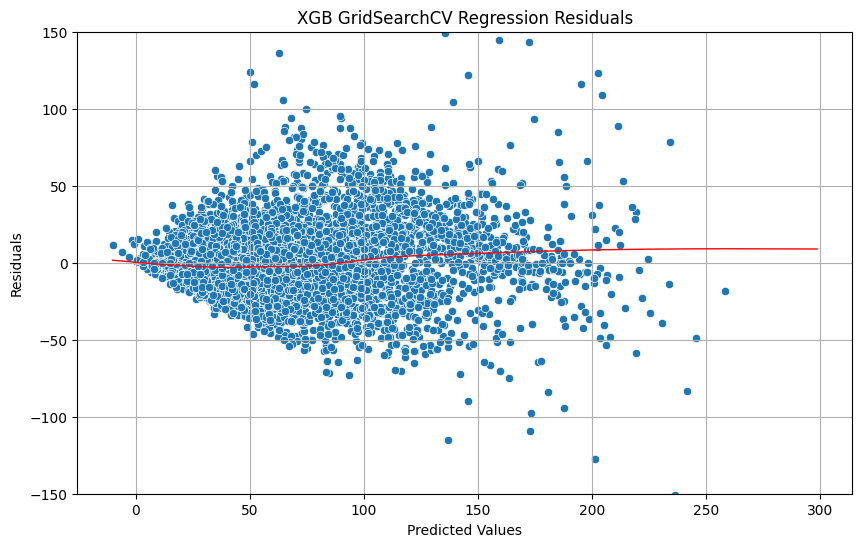

In [34]:
param_xgboost = {
    'xgb__n_estimators': [100, 300, 500],  # More trees might be better up to a point governed by diminishing returns
    'xgb__max_depth': [3, 5, 7],  # Deeper trees can capture more complex patterns
    'xgb__learning_rate': [0.01, 0.05, 0.1],  # Smaller learning rates should be paired with more trees
    'xgb__subsample': [0.7, 0.9],  # Subsampling approximately 70-90% of the data avoids overfitting
    'xgb__colsample_bytree': [0.5, 0.7]  # Using about 50-70% of columns for each tree
}

pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror'))
])


best_model_xgb, y_test_pred = train_grid_cv(
                                X_train,X_test,y_train,y_test,pipe_xgb,param_xgboost,
                                search_type='grid',reg_name='xgb',scoring_func = rmse_scoring)

plot_residuals(y_test,y_test_pred,'XGB GridSearchCV',y_limits=[-150,150])


**RandomizedSearchCV**

Best score:
-28.01
Best parameters:
{'xgb__subsample': 0.9, 'xgb__n_estimators': 300, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 0.7}
Root Mean Squared Error: 24.76
R^2 Score: 0.72
Adj. R^2 Score: 0.72


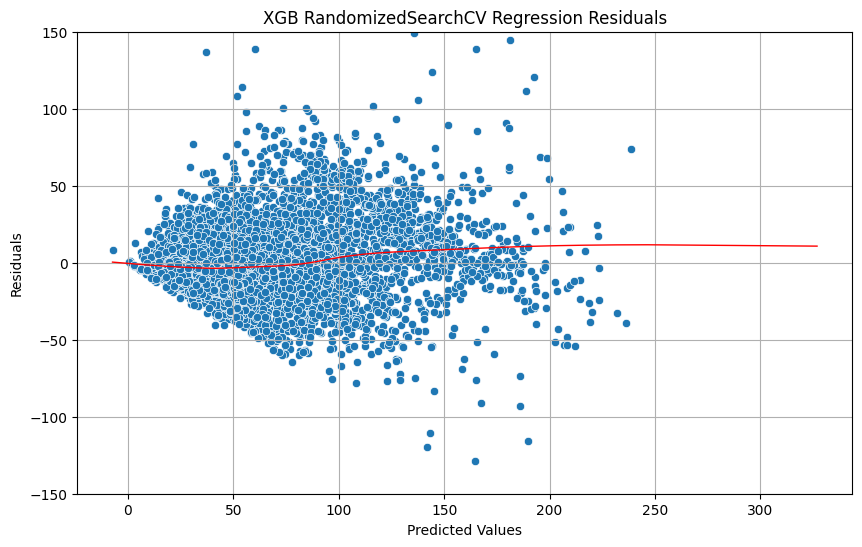

In [32]:
# Defining parameter space for grid-search
param_xgboost = {
    'xgb__n_estimators': [100, 300, 500],  # More trees might be better up to a point governed by diminishing returns
    'xgb__max_depth': [3, 5, 7],  # Deeper trees can capture more complex patterns
    'xgb__learning_rate': [0.01, 0.05, 0.1],  # Smaller learning rates should be paired with more trees
    'xgb__subsample': [0.7, 0.9],  # Subsampling approximately 70-90% of the data avoids overfitting
    'xgb__colsample_bytree': [0.5, 0.7]  # Using about 50-70% of columns for each tree
}


pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror'))
])


best_model_xgb_random, y_test_pred = train_grid_cv(
                                X_train,X_test,y_train,y_test,pipe_xgb,param_xgboost,
                                search_type='random',reg_name='xgb',scoring_func = rmse_scoring)

plot_residuals(y_test,y_test_pred,'XGB RandomizedSearchCV',y_limits=[-150,150])


/Users/carlosduque/Documents/neuefische/cgn-ds-24-2/project_2_ML/ds-air-pollution-challenge/.venv/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


<Axes: >

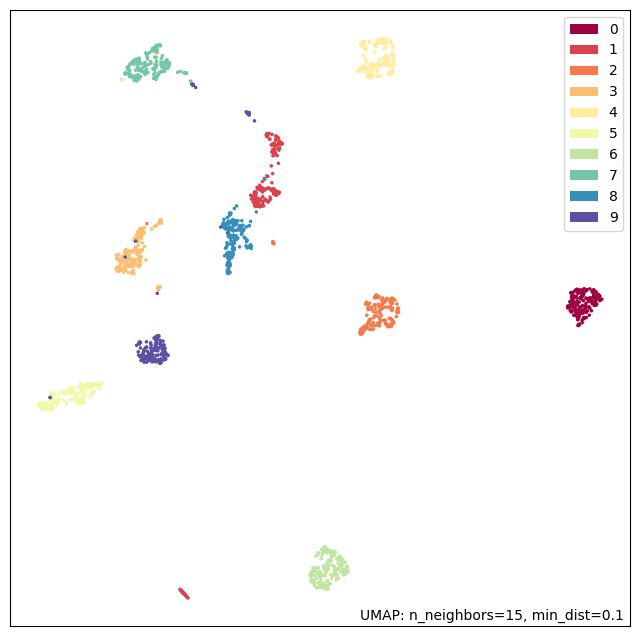

In [2]:
import umap
import umap.plot

from sklearn.datasets import load_digits

digits = load_digits()

mapper = umap.UMAP().fit(digits.data)
umap.plot.points(mapper, labels=digits.target)

In [3]:
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

In [5]:
import pandas as pd

penguins = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv")
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [6]:
penguins = penguins.dropna()
penguins.species.value_counts()

species
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64